### Normal Simulation

In [1]:
from Organoid import Organoid
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

org = Organoid()
org.nofSteps = 2
org.signal = 'dispersion'
org.evolution(T=0, file = 'organoid_mid.csv', ignore=['displacement', 'division'])
org.cellPlot()

[1, 6, 12]


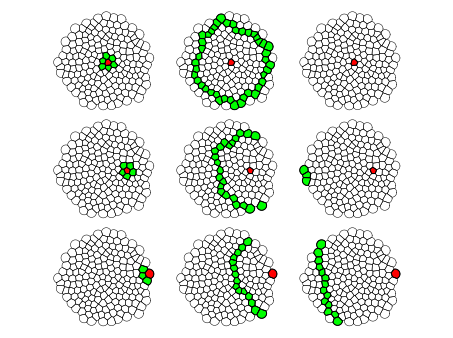

In [8]:
from shapely.geometry import Point, Polygon
from scipy.spatial.distance import cdist

def cell_pairs(ID, cell_dist):
    if org.dim == 2:
        r = org.r.mean()*np.ones(org.nofCells)

        #### polygon construction ####
        polygons = []

        cells = [Point(org.pos[i,:]).buffer(r[i]) for i in range(org.nofCells)]
        if org.nofCells == 1:
            polygons.append(cells[0])
        else:
            org.dist = cdist(org.pos, org.pos)
            for i in range(org.nofCells):
                indices = np.where((org.dist[i,:] < r[i] + r[:]) & (org.dist[i,:] != 0))
                cell1 = cells[i]

                d = org.dist[i,indices[0]]
                r_neigh = r[indices] 
                a = (r[i]**2 - r_neigh**2 + d**2)/(2*d)
                d12 = org.pos[indices[0],:] - org.pos[i,:]
                d12_orth = np.array([d12[:,1],-d12[:,0]]).T

                rect1 = org.pos[i,:] + d12/d[:,None]*a[:,None] + d12_orth/d[:,None]*r[i]
                rect2 = org.pos[i,:] - d12/d[:,None]*r[i] + d12_orth/d[:,None]*r[i]
                rect3 = org.pos[i,:] - d12/d[:,None]*r[i] - d12_orth/d[:,None]*r[i]
                rect4 = org.pos[i,:] + d12/d[:,None]*a[:,None] - d12_orth/d[:,None]*r[i]

                for j in range(len(indices[0])):

                    rectangle = np.array([rect1[j,:],rect2[j,:],rect3[j,:],rect4[j,:]])
                    rectangle = Polygon(rectangle)

                    cell1 = cell1.intersection(rectangle)

                polygons.append(cell1)    

        #### plot polygons ####

        for i in range(org.nofCells):
            x, y = polygons[i].exterior.xy
            plt.plot(x, y, 'k', lw=0.5)

            #plt.text(org.pos[i,0], org.pos[i,1], str(i),horizontalalignment='center',verticalalignment='center')

        x,y = polygons[ID].exterior.xy
        plt.fill(x,y, facecolor=[1,0,0,1], edgecolor='k', linewidth=1, zorder=1)
        IDs = np.where(org.GraphDist[:,ID] == cell_dist)[0]
        for i in IDs:
            x,y = polygons[i].exterior.xy
            plt.fill(x,y, facecolor=[0,1,0,1], edgecolor='k', linewidth=1, zorder=1)

        #### plot cell nuclei ####
        #plt.scatter(org.pos[:,0],org.pos[:,1], color='k', s=100, zorder=2)
        plt.axis('equal')
        plt.axis('off')
        
    return

cols = 3
dists = [1, 6, 12] #np.round(np.linspace(1,15,cols))
print(dists)
IDs = [13, 174, 25]
plt.figure(figsize=(6.4,4.8))
for i in range(len(IDs)):
    for j in range(cols):
        plt.subplot(3, cols, cols*i + j + 1)
        cell_pairs(IDs[i], dists[j])
        
#plt.tight_layout()
#plt.subplots_adjust(wspace=-3, hspace=0.0)
plt.tight_layout(h_pad=0, w_pad=-7)
plt.savefig('Results/PhD Thesis/Moran examples/rings.png', transparent = True)
plt.savefig('Results/PhD Thesis/Moran examples/rings.pdf', transparent = True)

### PCF examples

#### Mesh divided cell clusters

0.15176146632727408


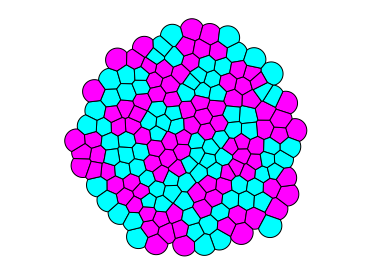

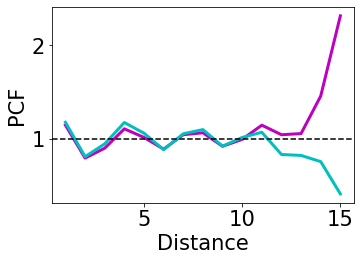

In [23]:
org.mesh = {}

# Number of lines in that dimension which cut through the organoid
Nx = 5
Ny = 5

x = np.linspace(np.min(org.pos[:,0]) - org.r_max/2, np.max(org.pos[:,0]) + org.r_max/2, Nx+2)
y = np.linspace(np.min(org.pos[:,1]) - org.r_max/2, np.max(org.pos[:,1]) + org.r_max/2, Ny+2)

org.G = np.zeros(org.nofCells)
for i in range(Nx+1):
    for j in range(Ny+1):
        if (i+j)%2 == 0:
            org.G[(x[i] <= org.pos[:,0]) & (org.pos[:,0] < x[i+1]) & (y[j] <= org.pos[:,1]) & (org.pos[:,1] < y[j+1])] = 1   

plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
org.N = 1 - org.G
org.cellPlot(org.G, size=0)
plt.savefig('test.png', transparent=True)
plt.savefig('Results/PhD Thesis/PCF examples/Org_nx='+str(Nx)+'_ny='+str(Ny)+'.png', transparent = True)
plt.savefig('Results/PhD Thesis/PCF examples/Org_nx='+str(Nx)+'_ny='+str(Ny)+'.pdf', transparent = True)

#im = plt.imread('test.png')

fig=plt.figure()
org.pcf(font_size = 14*3/2, lw = 3)
plt.ylabel('PCF')
plt.gcf().subplots_adjust(bottom=0.2)
plt.gcf().subplots_adjust(left=0.2)
#newax = fig.add_axes([.64,.64,0.5,0.5], zorder=1)
#newax.imshow(im)
#newax.axis('off')
plt.savefig('Results/PhD Thesis/PCF examples/PCF_nx='+str(Nx)+'_ny='+str(Ny)+'.png', transparent = True)
plt.savefig('Results/PhD Thesis/PCF examples/PCF_nx='+str(Nx)+'_ny='+str(Ny)+'.pdf', transparent = True)

org.moran()
print(org.Morans_I)

#### Radially divided cell clusters

-0.03866488318042686


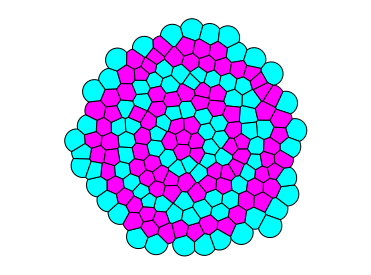

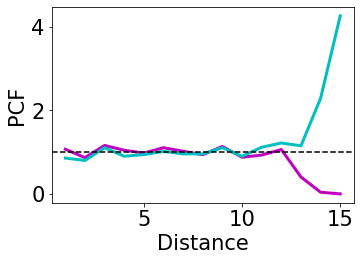

In [27]:
center = np.mean(org.pos, axis=0)
norm = ((org.pos[:,0]-center[0])**2 + (org.pos[:,1]-center[1])**2)**0.5
r_max = np.max(norm)

Nr = 5
r = np.linspace(0,r_max,Nr+2)

org.G = np.zeros(org.nofCells)
for i in range(Nr+1):
    if i%2 == 0:
        org.G[(r[i] < norm) & (norm <= r[i+1])] = 1

plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
org.N = 1 - org.G
org.cellPlot(org.G, size=0)
#plt.savefig('test.png', transparent=True)
plt.savefig('Results/PhD Thesis/PCF examples/Org_nr='+str(Nr)+'.png', transparent = True)
plt.savefig('Results/PhD Thesis/PCF examples/Org_nr='+str(Nr)+'.pdf', transparent = True)

#im = plt.imread('test.png')
#
fig=plt.figure()
org.pcf(font_size = 14*3/2, lw=3)
plt.ylabel('PCF')
plt.gcf().subplots_adjust(bottom=0.2)
plt.gcf().subplots_adjust(left=0.2)
#newax = fig.add_axes([.64,.64,0.5,0.5], zorder=1)
#newax.imshow(im)
#newax.axis('off')

plt.savefig('Results/PhD Thesis/PCF examples/PCF_nr='+str(Nr)+'.png', transparent = True)
plt.savefig('Results/PhD Thesis/PCF examples/PCF_nr='+str(Nr)+'.pdf', transparent = True)

org.moran()
print(org.Morans_I)

### Cell pair visualization

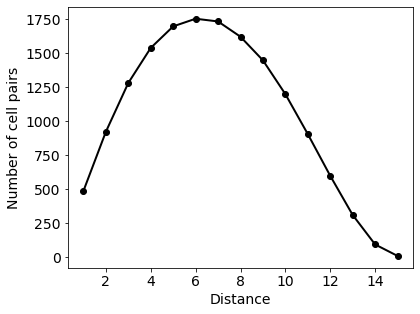

In [256]:
plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)

pairs = np.empty(int(np.max(org.GraphDist)))
for i in range(len(pairs)):
    pairs[i] = len(org.GraphDist[org.GraphDist == i+1])/2
    
distances = list(range(1,len(pairs)+1))

plt.plot(distances, pairs, lw = 2, marker='o', color='k')
plt.gcf().subplots_adjust(left=0.15)
plt.xlabel('Distance')
plt.ylabel('Number of cell pairs')
plt.savefig('Results/PhD Thesis/PCF examples/cell_pair_dist.png', transparent = True)
plt.savefig('Results/PhD Thesis/PCF examples/cell_pair_dist.pdf', transparent = True)

### Moran's I examples

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import pandas as pd

Nx = 4
Ny = 3
d = 1

xy = np.empty([Nx*Ny, 2])
for i in range(Nx):
    for j in range(Ny):
        print(i*Nx+j)
        xy[i*Nx+j] = [j*d, i*d]
        
def fate_distribution(org, dist_type):
    if dist_type == 'random':
        org.N = np.round(np.random.random(org.nofCells))
    if dist_type == 'cluster':
        center = np.mean(org.xy, axis=0)
        org.N = np.zeros(org.nofCells)
        org.N[org.xy[:,0] -  center[0] < 0] = 1
    if dist_type == 'checkerboard':
        for i in range(Nx):
            for j in range(Ny):
                if (i+j)%2==0:
                    org.N[i*Nx+j] = 1
    
    org.G = 1 - org.N
    
    return

import pandas as pd
df = pd.DataFrame()
df['x-Position'] = xy[:,0]
df['y-Position'] = xy[:,1]
df['Radius'] = np.ones(len(xy))*0.7
df.to_csv('8x8.csv', index = False)

from Organoid2D import Organoid

org = Organoid()
org.GraphDist = np.zeros([len(xy), len(xy)])
for i in range(len(xy)):
    org.GraphDist[i, neighbors(i, Nx)] = 1
    
org.evolution(T=0.001, file='8x8.csv', mode="transcription")


fate_distribution(org, 'cluster')

plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
org.cellPlot(org.N, size=0)

org.moran()
print(org.Morans_I)

#plt.savefig('Results/PhD Thesis/Moran examples/I='+"{:.3f}".format(org.Morans_I)+'.png', transparent = True)
#plt.savefig('Results/PhD Thesis/Moran examples/I='+"{:.3f}".format(org.Morans_I)+'.pdf', transparent = True)

0
1
2
4
5
6
8
9
10
12


IndexError: index 12 is out of bounds for axis 0 with size 12

In [49]:
xy

array([[ 0.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 2.        ,  0.        ],
       [ 3.        ,  0.        ],
       [ 4.        ,  0.        ],
       [ 5.        ,  0.        ],
       [ 6.        ,  0.        ],
       [ 7.        ,  0.        ],
       [ 0.        ,  1.        ],
       [ 1.        ,  1.        ],
       [ 2.        ,  1.        ],
       [ 3.        ,  1.        ],
       [ 4.        ,  1.        ],
       [ 5.        ,  1.        ],
       [ 6.        ,  1.        ],
       [ 7.        ,  1.        ],
       [ 0.        ,  2.        ],
       [ 1.        ,  2.        ],
       [ 2.        ,  2.        ],
       [ 3.        ,  2.        ],
       [ 4.        ,  2.        ],
       [ 5.        ,  2.        ],
       [ 6.        ,  2.        ],
       [ 7.        ,  2.        ],
       [ 0.        ,  3.        ],
       [ 1.        ,  3.        ],
       [ 2.        ,  3.        ],
       [ 3.        ,  3.        ],
       [ 4.        ,

### Visualization of forces acting on two cells

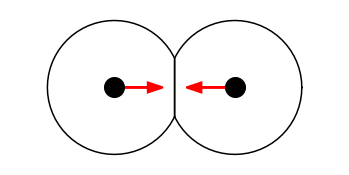

In [236]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from Organoid2D import Organoid

org = Organoid()
d = 0.9
org.xy = np.array([[-d,0],[d,0]])
org.r = np.array([1, 1])
org.nofCells = 2
org.dist = cdist(org.xy, org.xy)

plt.figure()
org.cellPlot(size = 400)
#plt.axis('on')
for xy in org.xy:
    if d < 0.7:
        plt.arrow(xy[0], xy[1], np.sign(xy[0])*0.5, 0, head_width=.15, lw=2, color='r')
    if d > 0.7 and d < 1:
        plt.arrow(xy[0], xy[1], -np.sign(xy[0])*0.5, 0, head_width=.15, lw=2, color='r')
plt.axis('square')
plt.xlim([-2.5,2.5])
plt.ylim([-1.2,1.2])

plt.savefig('Results/PhD Thesis/Displacement pictures/cells_d='+str(d)+'.png', transparent = True)
plt.savefig('Results/PhD Thesis/Displacement pictures/cells_d='+str(d)+'.pdf', transparent = True)

### Morse potential

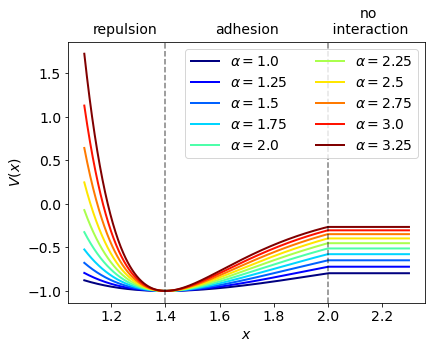

In [206]:
import matplotlib

cmap = matplotlib.cm.get_cmap('jet')

def morse_potential(x, a, σ):
    V = np.exp(-2*a*(x - σ*2)) - 2*np.exp(-a*(x - σ*2))
    V[x >= 2] = np.exp(-2*a*(2 - σ*2)) - 2*np.exp(-a*(2 - σ*2))
    return V

N = 10
x = np.linspace(1.1,2.3,1000)
A = np.linspace(1,3.25,N)
plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
color_spacing = np.linspace(0,1,N)
for i in range(N):
    rgba = cmap(color_spacing[i])
    plt.plot(x, morse_potential(x, A[i], 0.7), label="$\\alpha = " + str(A[i]) + "$", lw=2, color=rgba)
    
plt.axvline(1.4, color='k', ls='dashed', alpha = 0.5)
plt.axvline(2, color='k', ls='dashed', alpha = 0.5)
plt.xlabel("$x$")
plt.ylabel("$V(x)$")

y0, y1 = plt.ylim()
y = y1 + .03*(abs(y0)+abs(y1))
plt.text((x[0]+1.4)/2,y,"repulsion",horizontalalignment='center')
plt.text((1.4+2)/2,y,"adhesion",horizontalalignment='center')
plt.text((x[-1]+2)/2,y,"no\n interaction",horizontalalignment='center')
plt.legend(ncol=2)
plt.savefig('Results/PhD Thesis/Displacement pictures/morse_potential.png', transparent = True)
plt.savefig('Results/PhD Thesis/Displacement pictures/morse_potential.pdf', transparent = True)

### Morse potential derivative (force)

2.21 -5.0 2.0


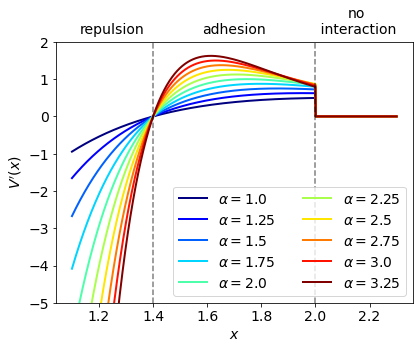

In [238]:
def morse_force(x, a, σ):
    F = - 2*a*np.exp(-2*a*(x - σ*2)) + 2*a*np.exp(-a*(x - σ*2))
    F[x >= 2] = 0
    return F

N = 10
x = np.linspace(1.1,2.3,1000)
A = np.linspace(1,3.25,N)
plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
color_spacing = np.linspace(0,1,N)
for i in range(N):
    rgba = cmap(color_spacing[i])
    plt.plot(x, morse_force(x, A[i], 0.7), label="$\\alpha = " + str(A[i]) + "$", lw=2, color=rgba)
    
plt.axvline(1.4, color='k', ls='dashed', alpha = 0.5)
plt.axvline(2, color='k', ls='dashed', alpha = 0.5)
plt.xlabel("$x$")
plt.ylabel("$V'(x)$")

y0, y1 = plt.ylim([-5,2])
y = y1 + .03*(abs(y0)+abs(y1))
print(y, y0, y1)
plt.text((x[0]+1.4)/2,y,"repulsion",horizontalalignment='center')
plt.text((1.4+2)/2,y,"adhesion",horizontalalignment='center')
plt.text((x[-1]+2)/2,y,"no\n interaction",horizontalalignment='center')
plt.legend(ncol=2)
plt.savefig('Results/PhD Thesis/Displacement pictures/morse_force.png', transparent = True)
plt.savefig('Results/PhD Thesis/Displacement pictures/morse_force.pdf', transparent = True)

### Cell division distance using Lambert W function <span style="color:red">(does not work since function argument is $-<\frac{1}{e}$)</span>

-0.09969792046063913 -0.36787944117144233
-0.06870494983790335 -0.36787944117144233
-0.054482661416751066 -0.36787944117144233
-0.04891085200377088 -0.36787944117144233
-0.047982405417245966 -0.36787944117144233
-0.04961289525424915 -0.36787944117144233
-0.05267941765222728 -0.36787944117144233
-0.05656224972204125 -0.36787944117144233
-0.06091345070883331 -0.36787944117144233
-0.06553522843973264 -0.36787944117144233


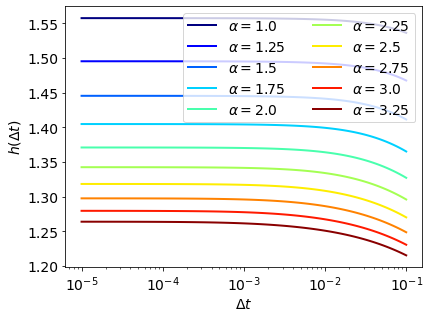

In [356]:
from scipy.special import lambertw

a = 1
F0 = .1
r = 0.95/2**(1/3)
s = 0.7

DT = np.logspace(-5,-1,K)

N = 10
A = np.linspace(1,3.25,N)
color_spacing = np.linspace(0,.99,N)

K = 100
DT = np.logspace(-5,-1,K)
plt.figure(figsize=[6.4, 4.8])

plt.rc('font', size=14)
for i in range(N):
    H = np.empty(K)
    rgba = cmap(color_spacing[i])
    for j in range(K):
        rhs = - 2*A[i]*F0*DT[j] + np.exp(-2*A[i]*s*r) + np.log(1 - np.exp(-2*A[i]*s*r))
        x = np.log(-lambertw(-np.exp(rhs-1))+1)
        H[j] = np.real(x/A[i] + 2*s*r)
    
    print(rhs, -1/np.exp(1))
    plt.plot(DT, H, label="$\\alpha = " + str(A[i]) + "$", lw=2, color=rgba)

plt.xscale('log')
plt.xlabel("$\Delta t$")
plt.ylabel("$h(\Delta t)$")
plt.legend(ncol=2)

### Cell division distance using nonlinear solver

C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':
C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':
C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log


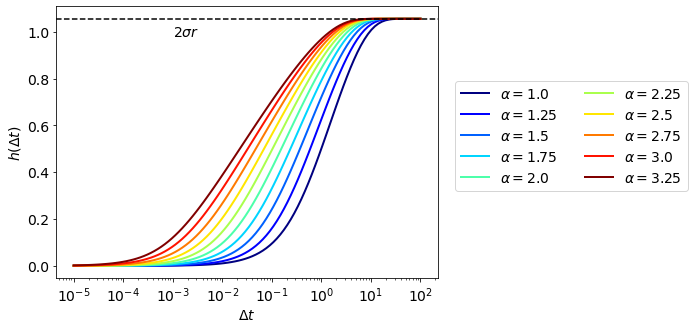

In [146]:
from scipy.optimize import fsolve
import matplotlib

cmap = matplotlib.cm.get_cmap('jet')

a = 1
F0 = .1
r = 0.95/2**(1/3)
sigma = 0.7

f = lambda h, dt, a: 2*a*F0*dt + np.exp(a*(h-2*r*sigma)) + np.log(1 - np.exp(a*(h-2*r*sigma))) \
                    - np.exp(a*(-2*r*sigma)) - np.log(1 - np.exp(a*(-2*r*sigma)))

N = 10
A = np.linspace(1,3.25,N)
color_spacing = np.linspace(0,1,N)

K = 100
DT = np.logspace(-5,2,K)

plt.figure(figsize=[11, 4.8])
plt.rc('font', size=14)
for i in range(N):
    H = np.empty(K)
    rgba = cmap(color_spacing[i])
    for j in range(K):
        F = lambda h: f(h, DT[j], A[i])
        dF = lambda h: -A[i]*np.exp(A[i]*(h-2*r*sigma))/(np.exp(-A[i]*(h-2*r*sigma))-1)
        H[j] = fsolve(F, 1.9999*sigma*r, fprime=dF)
        
    plt.plot(DT, H, label="$\\alpha = " + str(A[i]) + "$", lw=2, color=rgba)

plt.text(0.001,2*sigma*r - 0.075,"$2 \\sigma r$")
plt.axhline(2*sigma*r, linestyle='dashed', color='k', zorder=10)
plt.xscale('log')
plt.xlabel("$\Delta t$")
plt.ylabel("$h(\Delta t)$")
plt.legend(ncol=2, loc='upper center', bbox_to_anchor=(1.35, .75))

#plt.gcf().subplots_adjust(right=0.5)
plt.tight_layout()
plt.savefig('Results/PhD Thesis/Displacement pictures/division_distance.png', transparent = True)
plt.savefig('Results/PhD Thesis/Displacement pictures/division_distance.pdf', transparent = True)

In [453]:
print(a)
print(F0)
print(r)
print(sigma)

1
0.1
0.7540154996848947
0.7


### Radius growth equation

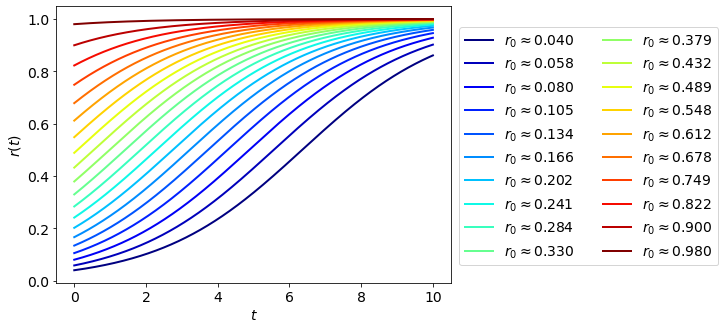

In [104]:
import matplotlib

def radius(t, k, r0, r_max):
    return r_max/(1 + ((r_max - r0)/r0)*np.exp(-k*r_max*t))

cmap = matplotlib.cm.get_cmap('jet')

k = 0.5
r_max = 1
T = 10
nofSteps = 1000
t = np.linspace(0,T,nofSteps)

f = lambda r: k*r*(r_max - r)

N = 20
r0 = np.linspace(0.2,0.99,N)**2
#r0 = np.logspace(-3,0,N)
color_spacing = np.linspace(0,1,N)

plt.figure(figsize=[11.5, 4.8])
plt.rc('font', size=14)
for i in range(N):
    
    rgba = cmap(color_spacing[i])
    r = radius(t, k, r0[i], r_max)
    
    plt.plot(t, r, label="$r_0 \\approx " + "{:.3f}".format(r0[i]) + "$", lw=2, color=rgba)
    
plt.xlabel('$t$')
plt.ylabel('$r(t)$')
plt.legend(ncol=2, loc='upper center', bbox_to_anchor=(1.35, 0.95))

plt.tight_layout()

plt.savefig('Results/PhD Thesis/Radius pictures/radius_logistic.png', transparent = True)
plt.savefig('Results/PhD Thesis/Radius pictures/radius_logistic.pdf', transparent = True)

### Equations of motion (fully inert / constant mass / none)

6.4641824147938136e-24 6.4641824147938136e-24 9.320058205649722e-16 4.188790204786391e-12 144180000.00000003


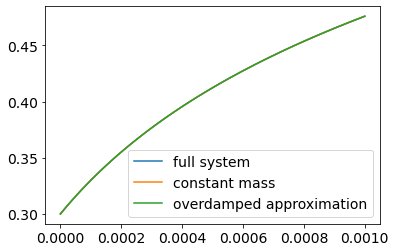

In [246]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def morse_force(x, r, a, σ):
    F = - 2*a*np.exp(-2*a*(x - σ*r*2)) + 2*a*np.exp(-a*(x - σ*r*2))
    if F >= 2:
        F = 0
    return F

def radius(t, k, r0, r_max):
    return r_max/(1 + ((r_max - r0)/r0)*np.exp(-k*r_max*t))

x_ref = 2*1e-5
m_ref = 4/3*np.pi*(x_ref/2)**3*1e3
b = 3*np.pi*8.9*1e-4*x_ref
T_ref = 3600
k = .5

α = m_ref*x_ref/T_ref**2
β = m_ref*x_ref/T_ref**2
γ = b*x_ref/T_ref
F0 = 1e-15
print(α, β, γ, m_ref, γ/α)

N = 10000
t = np.linspace(0,0.001,N)

def f_full(u,t):
    x = u[0]
    v = u[1]
    
    r = radius(t, k, 0.7, 1)
    dm = 4*np.pi*0.5*r**3*(1 - r)
    
    F = morse_force(x, r, 3, 0.7)
    
    rhs = np.empty(len(u))
    rhs[0] = v
    rhs[1] = - β/α*dm*v - γ/α*v - F0/α*F
    
    return rhs

def f_mass(u,t):
    x = u[0]
    v = u[1]
    
    r = radius(t, k, 0.7, 1)
    F = morse_force(x, r, 3, 0.7)
    
    rhs = np.empty(len(u))
    rhs[0] = v
    rhs[1] = - γ/α*v - F0/α*F
    
    return rhs

def f_none(u,t):
    x = u[0]
    
    r = radius(t, k, 0.7, 1)
    F = morse_force(x, r, 3, 0.7)
    
    rhs = - F0/γ*F
    
    return rhs

u_full = odeint(f_full, [.3,0], t)
u_mass = odeint(f_mass, [.3,0], t)
u_none = odeint(f_none, .3, t)

plt.plot(t, u_full[:,0], label='full system')
plt.plot(t, u_mass[:,0], label='constant mass')
plt.plot(t, u_none, label='overdamped approximation')
plt.legend()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

T = 10
N = 10000
t = np.linspace(0,T,N)
dt = t[1]-t[0]

x = np.zeros(N)
u = np.zeros(N)
y = np.zeros(N)
v = np.zeros(N)
m = np.zeros(N)
z = np.zeros(N)

k = 30
M = 10
m_max = 1.2*M
alpha = 1

γ = 60

z[0] = 1

def f1(u,t):
    x = u[0]
    v = u[1]
    
    rhs = np.empty(len(u))
    rhs[0] = v
    rhs[1] = -k/M*x - γ/M*v
    
    return rhs

def f2(u,t):
    x = u[0]
    v = u[1]
    m = u[2]
    
    rhs = np.empty(len(u))
    rhs[0] = v
    rhs[1] = - k/m*x - γ/m*v + alpha*(m_max - m)*v
    rhs[2] = alpha*m*(m_max - m)
    
    return rhs

def f3(u,t):
    return -k*u/γ

u1 = odeint(f1, [1,0], t)
u2 = odeint(f2, [1,0,0.7*M], t)
u3 = odeint(f3, 1, t)
    
plt.plot(t, u1[:,0], label='constant mass')
plt.plot(t, u2[:,0], label='variable mass')
plt.plot(t, u3, label='overdamped appr.')
plt.legend()

print('damping ratio =', γ/2/(M*k)**(1/2))

### Organoid growth rate

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from Organoid import Organoid
from scipy.optimize import curve_fit
import pandas as pd

N = 100
T = np.random.uniform(1,24,N)

nofCells = np.empty(N)
for i in range(N):
    org = Organoid()
    org.k = 0.07
    org.evolution(T=30, dim=2, ignore=['transcription', 'displacement'])
    nofCells[i] = org.nofCells
    
plt.scatter(T, nofCells)
plt.plot(T, np.exp(Λ1*T), label = "$\\Lambda_{0,24}$")
plt.plot(T, np.exp(Λ2*T), label = "$\\Lambda_{24,48}$")
plt.plot(T, np.exp(Λ3*T), label = "$\\Lambda_{0,48}$")
#plt.yscale('log')

#popt, _ = curve_fit(f, )

KeyboardInterrupt: 

In [1]:
import pandas as pd

Data = pd.read_csv('Data/includingSurfaceDistance/extendedRawDataICMOrganoids.csv')
Data

OrganoidID stage  Batch1   CentroidX   CentroidY   CentroidZ  \
0               1   24h  Batch1  387.920586  340.592025  288.091002   
1               1   24h  Batch1  342.532992  265.831342  279.278441   
2               1   24h  Batch1  327.711859  244.676250  278.521725   
3               1   24h  Batch1  265.004217  259.705607  280.917673   
4               1   24h  Batch1  365.736937  259.704124  271.419047   
...           ...   ...     ...         ...         ...         ...   
58746          76   24h  Batch7  204.691729  280.157895   10.958647   
58747          76   24h  Batch7  203.823077  204.700000    8.869231   
58748          76   24h  Batch7  200.106932  179.018174    3.491547   
58749          76   24h  Batch7  211.472222  228.833333    3.750000   
58750          76   24h  Batch7  218.033333  246.313333    1.033333   

      Population  DCGNeighborCount  Nanog-Avg  Gata6-Avg  SurfaceNearestX  \
0           N-G-               8.0   0.004876   0.016318       387.920586   
1           N-G+              15.0   0.009083   0.093308       342.532992   
2           N-G+              12.0   0.009239   0.127786       327.711859   
3           N+G-              14.0   0.022990   0.039204       265.004217   
4           N-G+              13.0   0.009302   0.133818       365.736937   
...          ...               ...        ...        ...              ...   
58746       N-G-              14.0   0.013568   0.020156       204.691729   
58747       N+G-              11.0   0.022507   0.015512       202.517971   
58748       N-G-              15.0   0.011799   0.016617       200.106932   
58749       N+G+              13.0   0.019262   0.092203       211.472222   
58750       N+G-              20.0   0.027019   0.039094       218.033333   

       SurfaceNearestY  SurfaceNearestZ  SurfaceDistance  
0           340.592025       288.091002         0.000000  
1           265.831342       279.278441         0.000000  
2           244.676250       278.521725         0.000000  
3           259.705607       280.917673         0.000000  
4           259.704124       271.419047         0.000000  
...                ...              ...              ...  
58746       280.157895        10.958647         0.000000  
58747       205.019187         4.739090         4.343184  
58748       179.018174         3.491547         0.000000  
58749       228.833333         3.750000         0.000000  
58750       246.313333         1.033333         0.000000  

[58751 rows x 14 columns]

In [2]:
Data24 = Data[Data.stage == '24h']
Data48 = Data[Data.stage == '48h']

In [8]:
print(Data24.groupby("OrganoidID").size().mean())
print(Data24.groupby("OrganoidID").size().std())

print(Data48.groupby("OrganoidID").size().mean())
print(Data48.groupby("OrganoidID").size().std())

441.7352941176471
148.98389354141398
1041.2380952380952
306.82837099111924


In [23]:
import numpy as np

T = 3600
r = 1.5e-5
M = 4/3*np.pi*r**3*1.e3
μ = 8.9e-4
b = 6*np.pi*μ*r

print(2*M*r/T**2, 2*b*r/T)

3.272492347489368e-23 2.097013096271187e-15


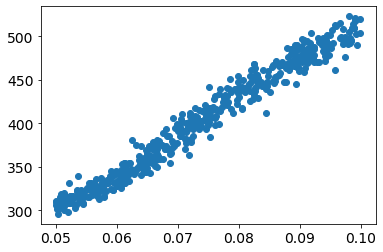

In [220]:
n0 = 200
n24 = 441.735294117647
n48 = 1041.2380952380954

N = 500
K = np.random.uniform(0.05,0.1,N)
dim = 3
dim_scal = 1/2**(1/dim)

nofCells = np.empty(N)
for j in range(len(K)):
    org = Organoid()
    org.k = K[j]
    
    initial_org = pd.DataFrame()
    initial_org['x-Position'] = np.random.uniform(0,1,200)
    initial_org['y-Position'] = np.random.uniform(0,1,200)
    initial_org['z-Position'] = np.random.uniform(0,1,200)
    initial_org['Radius'] = np.random.uniform(0.9*dim_scal, 1, 200)
    initial_org.to_csv('test.csv', index=False)
    
    org.evolution(T=24, dim=3, file='test.csv', ignore=['transcription', 'displacement'])
    nofCells[j] = org.nofCells
    
plt.scatter(K, nofCells)

0.08278662224952961


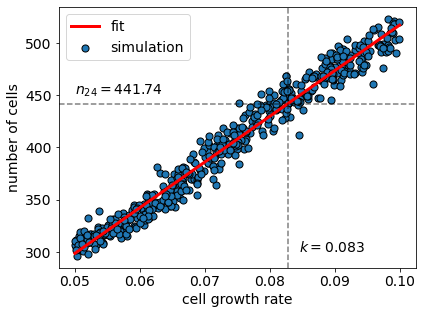

In [267]:
from scipy.optimize import curve_fit

plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
plt.scatter(K, nofCells, linewidths=1, edgecolors='k', label='simulation', s=50)
plt.axhline(n24, color = 'k', linestyle = 'dashed', alpha = 0.5)

k = np.linspace(0.05,0.1,1000)
f = lambda x, a, b: a*x + b

popt, pcov = curve_fit(f, K, nofCells)
plt.plot(k, f(k,*popt), color='r', lw=3, label='fit')
print(n24/popt[0] - popt[1]/popt[0])
plt.axvline(n24/popt[0] - popt[1]/popt[0], color = 'k', linestyle = 'dashed', alpha = 0.5)
plt.text(0.05,n24+n24*0.02,"$n_{24} = 441.74$")
plt.text(n24/popt[0] - popt[1]/popt[0]+(n24/popt[0] - popt[1]/popt[0])*0.02,300,"$k = 0.083$")
plt.legend()

plt.xlabel('cell growth rate')
plt.ylabel('number of cells')

plt.savefig('Results/PhD Thesis/Radius pictures/growth_rate_estimation.png', transparent = True)
plt.savefig('Results/PhD Thesis/Radius pictures/growth_rate_estimation.pdf', transparent = True)

In [222]:
N = 500
T = np.random.uniform(0,270,N)

nofCells2D = np.empty(N)
for j in range(N):
    org = Organoid()
    org.k = 0.083
    org.evolution(T=T[j], dim=2, ignore=['transcription', 'displacement'])
    nofCells2D[j] = org.nofCells
    
nofCells3D = np.empty(N)
for j in range(N):
    org = Organoid()
    org.k = 0.083
    org.evolution(T=T[j], dim=3, ignore=['transcription', 'displacement'])
    nofCells3D[j] = org.nofCells

[0.02453354] [0.02961006]


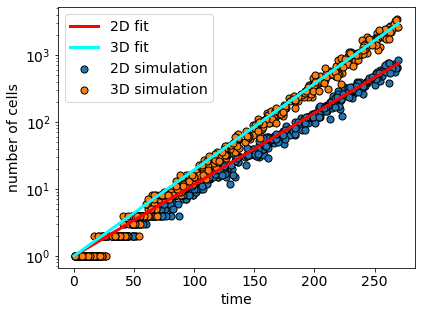

In [266]:
plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
plt.scatter(T, nofCells2D, linewidths=1, edgecolors='k', label='2D simulation', s=50)
plt.scatter(T, nofCells3D, linewidths=1, edgecolors='k', label='3D simulation', s=50)

t = np.linspace(0,270,1000)
f = lambda x, a: np.exp(a*x)

popt2D, pcov = curve_fit(f, T, nofCells2D, p0=0.03)
plt.plot(t, f(t,*popt2D), color='r', lw=3, label='2D fit')
popt3D, pcov = curve_fit(f, T, nofCells3D, p0=0.03)
plt.plot(t, f(t,*popt3D), color='cyan', lw=3, label='3D fit')
print(popt2D, popt3D)
plt.legend()
plt.yscale('log')
plt.xlabel('time')
plt.ylabel('number of cells')

plt.savefig('Results/PhD Thesis/Radius pictures/population_growth.png', transparent = True)
plt.savefig('Results/PhD Thesis/Radius pictures/population_growth.pdf', transparent = True)

In [271]:
print(popt2D*24/np.log(2), popt3D*24/np.log(2))

[0.84946592] [1.02523883]


### Division probability

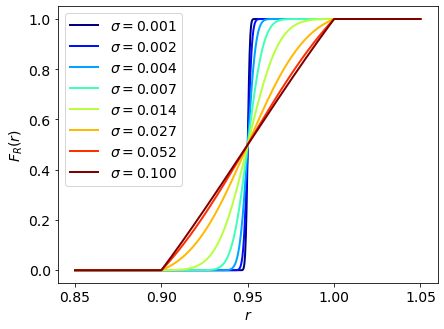

In [346]:
from scipy.special import erf
import matplotlib
                     
def truncated_normal_cdf(x, mu, sigma, interval):
    cdf = lambda y: (1 + erf(y/2**(1/2)))
    
    a = (interval[0] - mu)/sigma           
    b = (interval[1] - mu)/sigma
    z = (x - mu)/sigma
    
    CDF = (cdf(z) - cdf(a)) / (cdf(b) - cdf(a))
    CDF[CDF <= 0] = 0
    CDF[CDF >= 1] = 1
    return CDF

cmap = matplotlib.cm.get_cmap('jet')
N = 8
color_spacing = np.linspace(0,1,N)
x = np.linspace(0.85,1.05,1000)
σ = np.logspace(-3,-1,N)#[0.03, 0.015, 0.09]
plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
for i in range(N):
    
    rgba = cmap(color_spacing[i])
    
    plt.plot(x, truncated_normal_cdf(x, 0.95, σ[i], [0.9,1]), label="$\\sigma = " + "{:.3f}".format(σ[i]) + "$", lw=2, color=rgba)
    
plt.xlabel('$r$')
plt.xticks([0.85, 0.9, 0.95, 1, 1.05])
plt.ylabel('$F_R(r)$')
plt.legend()

plt.tight_layout()

plt.savefig('Results/PhD Thesis/Radius pictures/division_probability.png', transparent = True)
plt.savefig('Results/PhD Thesis/Radius pictures/division_probability.pdf', transparent = True)

Text(0, 0.5, 'test')

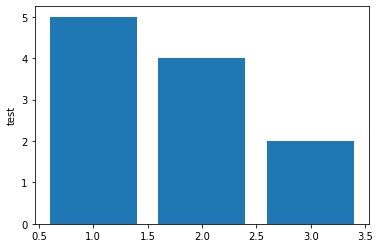

In [26]:
import matplotlib.pyplot as plt

plt.bar([1,2,3], [5,4,2])
plt.ylabel('test')

### Thermodynamic model

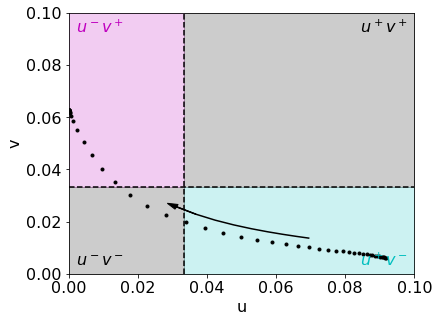

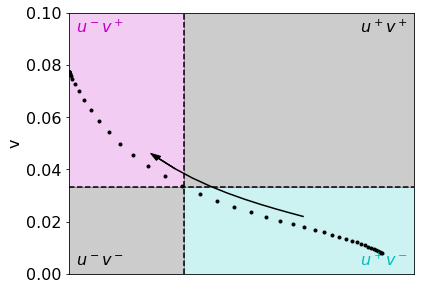

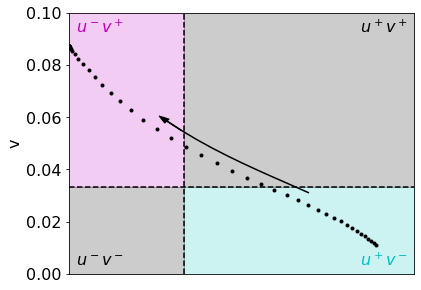

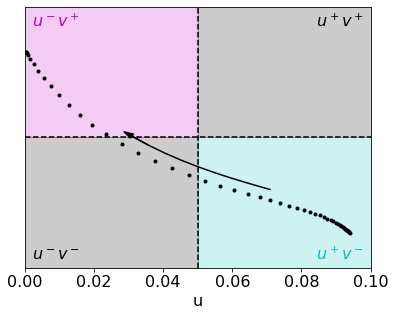

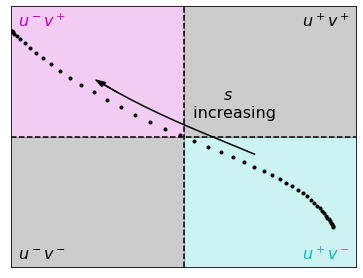

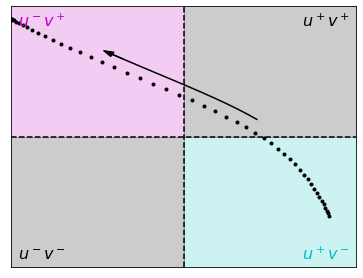

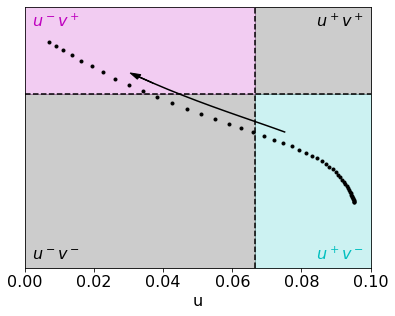

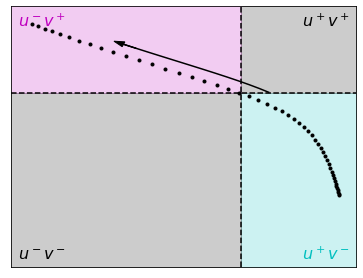

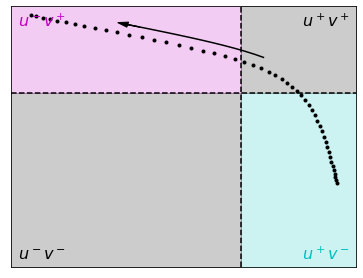

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

γ = 10
r = 1

basal_coeffs = [1/2, 1, 2]
signal_coeffs = [1/2, 1, 2]

for basal_coeff in basal_coeffs:
    for signal_coeff in signal_coeffs:
        x = 1e-1
        eta_x = basal_coeff*1e1

        eta_u = np.exp(5)
        eta_v = np.exp(5)

        eta_ux = np.exp(4)
        eta_vx = np.exp(1)
        
        p = lambda f: eta_x*x/(f + eta_x*x)

        u0 = p(1)*r/γ
        v0 = p(1)*r/γ
        s0 = p(1)*r/γ
        eta_s = ((1 + eta_u*eta_ux*u0)/(1 + eta_u*u0)/(1 + eta_v*v0) - 1)/s0
        eta_sx = signal_coeff*((1 + eta_u*u0)*(1 + eta_v*v0)*(1 + eta_s*s0)/(1 + eta_v*eta_vx*v0) - 1)/(eta_s*s0)

        p = lambda f: eta_x*x/(f + eta_x*x)

        f_u = lambda u, v, s: (1 + eta_u*u)*(1 + eta_v*v)*(1 + eta_s*s)/(1 + eta_u*eta_ux*u)
        f_v = lambda u, v, s: (1 + eta_u*u)*(1 + eta_v*v)*(1 + eta_s*s)/(1 + eta_v*eta_vx*v)/(1 + eta_s*eta_sx*s)

        def F(u, v, s):
            γ = 10
            r = 1

            U = r*p(f_u(u,v,s)) - γ*u
            V = r*p(f_v(u,v,s)) - γ*v

            return U, V

        N = 50
        u = np.empty(N)
        v = np.empty(N)
        for i, s in enumerate(np.logspace(-3,0,N)):
            f = lambda x: F(x[0], x[1], s)
            sol = fsolve(f, [1,1])
            u[i] = sol[0]
            v[i] = sol[1]

        plt.rcParams['font.size'] = 16
        plt.figure(figsize=[6.4, 4.8])
        plt.plot(u, v,'.', color='k', lw=3)
        plt.axhline(r/γ*p(1), color='k', alpha=1, linestyle='dashed')
        plt.axvline(r/γ*p(1), color='k', alpha=1, linestyle='dashed')
        plt.fill_between([0,r/γ*p(1)],[r/γ*p(1), r/γ*p(1)], [.1,.1], color='m', alpha = 0.2)
        plt.fill_between([r/γ*p(1),.1],[0, 0], [r/γ*p(1),r/γ*p(1)], color='c', alpha = 0.2)
        plt.fill_between([r/γ*p(1),.1],[r/γ*p(1),r/γ*p(1)],  [.1,.1], color='k', alpha = 0.2)
        plt.fill_between([0,r/γ*p(1)], [0,0], [r/γ*p(1),r/γ*p(1)], color='k', alpha = 0.2)
        plt.xlim([0, .1])
        plt.ylim([0, .1])
        plt.text(.1 - 0.002, .1 - 0.002, '$u^+v^+$', horizontalalignment='right', verticalalignment='top')
        plt.text(0+0.002, 0+0.002, '$u^-v^-$', horizontalalignment='left', verticalalignment='bottom')
        plt.text(0+0.002, .1-0.002, '$u^-v^+$', color='m', horizontalalignment='left', verticalalignment='top')
        plt.text(0.1-0.002, 0+0.002, '$u^+v^-$', color='c', horizontalalignment='right', verticalalignment='bottom')

        # Plot arrow
        arrow_u = u[(u >= (max(u)+min(u))/2 - (max(u)-min(u))/4) & (u <= (max(u)+min(u))/2 + (max(u)-min(u))/4)]
        arrow_v = v[(u >= (max(u)+min(u))/2 - (max(u)-min(u))/4) & (u <= (max(u)+min(u))/2 + (max(u)-min(u))/4)]
        plt.plot(arrow_u+0.003, arrow_v+0.003, color='k')
        plt.arrow(arrow_u[-2]+0.003, arrow_v[-2]+0.003, arrow_u[-1]-arrow_u[-2], arrow_v[-1]-arrow_v[-2], width=0.0001, head_width=0.002, color='k')
        if basal_coeff == 1 and signal_coeff == 1:
            plt.text(np.mean(arrow_u)+0.005, np.mean(arrow_v)+0.005, '       $s$ \n increasing')

        if basal_coeff == basal_coeffs[0]:
            plt.ylabel('v')
        else:
            plt.yticks([])
        if signal_coeff == signal_coeffs[0]:
            plt.xlabel('u')
        else:
            plt.xticks([])

        plt.gcf().subplots_adjust(left=0.15)
        plt.savefig('Results/PhD Thesis/Transcription pictures/st_states_thermo_eta='+str(signal_coeff)+'_x='+str(basal_coeff)+'.png', transparent = True)
        plt.savefig('Results/PhD Thesis/Transcription pictures/st_states_thermo_eta='+str(signal_coeff)+'_x='+str(basal_coeff)+'.pdf', transparent = True)

In [7]:
eta_s = ((1 + eta_u*eta_ux*u0)/(1 + eta_u*u0)/(1 + eta_v*v0) - 1)/s0
eta_sx = ((1 + eta_u*u0)*(1 + eta_v*v0)*(1 + eta_s*s0)/(1 + eta_v*eta_vx*v0) - 1)/(eta_s*s0)

print(eta_s, eta_sx)
print(np.log(eta_s), np.log(eta_sx))

53.4009294858746 5.168828875573468
3.977828151917185 1.6426461397601957


### Transcriptional regulation model comparison

[2.24863494e+00 9.99470470e+00 6.75250344e-02 3.31483377e+02
 4.56741920e+02 1.53995838e+01 1.08060954e+00]
[  0.99861668  10.71905449   7.02003434   7.63396916 941.98056099]


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


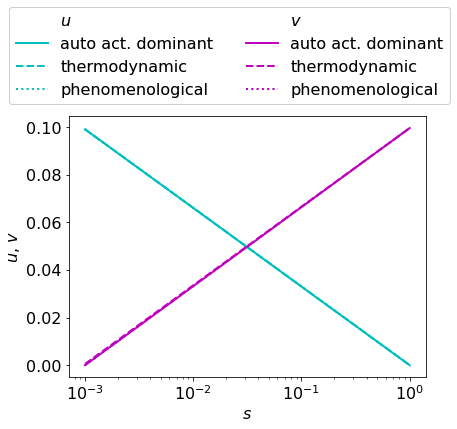

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, curve_fit

def F_auto_act(s):
    r = 1
    γ = 10

    eta_u = np.exp(7)
    eta_v = np.exp(6)
    eta_s = np.exp(2)
    eta_vs = np.exp(2)

    s_crit = (eta_u - eta_v)/(eta_v*eta_s*eta_vs)
    
    u = r/γ - (1+eta_s*s)/eta_u
    u[s > s_crit] = 0
    v = r/γ - (1+eta_s*s)/eta_v/(1+eta_s*eta_vs*s)
    v[s < s_crit] = 0

    return np.concatenate((u, v))

def F_thermodynamic(s, r, γ, x, eta_u, eta_v, eta_ux, eta_vx):
    #r, γ = 1, 10
    p = lambda f: x/(f + x)
    
    u0 = p(1)*r/γ
    v0 = p(1)*r/γ
    s0 = (np.exp(7) - np.exp(6))/(np.exp(6)*np.exp(2)*np.exp(2))
    
    eta_s = ((1 + eta_u*eta_ux*v0)/(1 + eta_u*u0)/(1 + eta_v*v0) - 1)/s0
    eta_sx = ((1 + eta_u*u0)*(1 + eta_v*v0)*(1 + eta_s*s0)/(1 + eta_v*eta_vx*v0) - 1)/(eta_s*s0)

    f_u = lambda u, v, s: (1 + eta_u*u)*(1 + eta_v*v)*(1 + eta_s*s)/(1 + eta_u*eta_ux*u)
    f_v = lambda u, v, s: (1 + eta_u*u)*(1 + eta_v*v)*(1 + eta_s*s)/(1 + eta_v*eta_vx*v)/(1 + eta_s*eta_sx*s)

    def F(u, v, s):

        x = np.empty(2)
        x[0] = r*p(f_u(u,v,s)) - γ*u
        x[1] = r*p(f_v(u,v,s)) - γ*v

        return x
    
    def dF(u, v, s):
        
        du_fu = (1 - eta_ux)*(1 + eta_v*v)*(1 + eta_s*s) / \
                (1 + eta_u*eta_ux*u)**2
        dv_fu = eta_v*(1 + eta_u*u)*(1 + eta_s*s) / \
                (1 + eta_u*eta_ux*u)
        du_fv = eta_u*(1 + eta_v*v)*(1 + eta_s*s) / \
                (1 + eta_v*eta_vx*v)/(1 + eta_s*eta_sx*s)
        dv_fv = (1 - eta_vx)*(1 + eta_u*u)*(1 + eta_s*s)*(1 + eta_s*eta_sx*s) / \
                (1 + eta_v*eta_vx*v)**2/(1 + eta_s*eta_sx*s)**2
            
        y = np.empty([2, 2])
        y[0,0] = -r*x/(f_u(u,v,s) + x)**2*du_fu - γ
        y[0,1] = -r*x/(f_u(u,v,s) + x)**2*dv_fu
        y[1,0] = -r*x/(f_v(u,v,s) + x)**2*du_fv
        y[1,1] = -r*x/(f_v(u,v,s) + x)**2*dv_fv - γ
        
        return y

    u = np.empty(len(s))
    v = np.empty(len(s))
    for i in range(len(s)):
        f = lambda x: F(x[0], x[1], s[i])
        df = lambda x: dF(x[0], x[1], s[i])
        sol = fsolve(f, [1,1], fprime = df)
        u[i] = sol[0]
        v[i] = sol[1]
    
    return np.concatenate((u, v))

def F_phenomenological(s, r, γ, a_u, a_v, a_s):
    #r, γ = 1, 10
    n = 2

    f_u = lambda u, v, s: r*(a_u*u**n/(1+a_u*u**n) + 1/(1+a_s*s**n))*1/(1+a_v*v**n) - γ*u
    f_v = lambda u, v, s: r*(a_v*v**n/(1+a_v*v**n) + a_s*s**n/(1+a_s*s**n))*1/(1+a_u*u**n) - γ*v

    def F(u, v, s):
        x = np.empty(2)
        x[0] = f_u(u,v,s)
        x[1] = f_v(u,v,s)

        return x
    
    def dF(u, v, s):
        x = np.empty([2,2])
        x[0,0] = r/(1+a_v*v**n)*n*a_u*u**(n-1)/(1 + a_u*u**n)**2 - γ
        x[0,1] = -r*(a_u*u**n/(1+a_u*u**n) + 1/(1+a_s*s**n))*n*a_v*v**(n-1)/(1 + a_v*v**n)**2
        x[1,0] = -r*(a_v*v**n/(1+a_v*v**n) + a_s*s**n/(1+a_s*s**n))*n*a_u*u**(n-1)/(1 + a_u*u**n)**2  
        x[1,1] = r/(1+a_u*u**n)*n*a_v*v**(n-1)/(1 + a_v*v**n)**2 - γ
        
        return x
    
    u = np.empty(len(s))
    v = np.empty(len(s))
    for i in range(len(s)):
        f = lambda x: F(x[0], x[1], s[i])
        df = lambda x: dF(x[0], x[1], s[i])
        sol = fsolve(f, [1,1], fprime=df)
        u[i] = sol[0]
        v[i] = sol[1]
    
    return np.concatenate((u, v))

s = np.logspace(-3,0,2)
y = F_auto_act(s)

popt1, pcov = curve_fit(F_thermodynamic, s, y, p0=[1, 10, 1, np.exp(5), np.exp(5), np.exp(4), np.exp(1)],
                        bounds=(0, [1000, 1000, 1000, 1000, 1000, 1000, 1000]), maxfev=100000)

popt2, pcov = curve_fit(F_phenomenological, s, y, p0=[1, 10, np.exp(2), np.exp(1), np.exp(5)],
                        bounds=(0, 1000), maxfev=10000)

print(popt1)
print(popt2)

x_fit = F_thermodynamic(s, *popt1)
x_fit2 = F_phenomenological(s, *popt2)

plt.rcParams['font.size'] = 16
plt.figure(figsize=[6.4, 4.8])
categories = ['auto act. dominant', 'thermodynamic', 'phenomenological']
p1,=plt.plot(s,y[:len(s)], 'c', lw=2)
p2,=plt.plot(s,y[len(s):], 'm', lw=2)
p3,=plt.plot(s,x_fit[:len(s)], 'c', ls='dashed', lw=2)
p4,=plt.plot(s,x_fit[len(s):], 'm', ls='dashed', lw=2)
p5,=plt.plot(s,x_fit2[:len(s)], 'c', ls='dotted', lw=2)
p6,=plt.plot(s,x_fit2[len(s):], 'm', ls='dotted', lw=2)
p7, = plt.plot([0], marker='None',
           linestyle='None', label='dummy-tophead')
plt.xscale('log')
plt.xlabel('$s$')
plt.ylabel('$u$, $v$')

leg = plt.legend([p7, p1, p3, p5, p7, p2, p4, p6],
                 [r'$u$'] + categories + [r'$v$'] + categories,
                 ncol=2,
                 loc='upper center', bbox_to_anchor=(0.45, 1.45))
plt.gca().add_artist(leg)
#plt.savefig('Results/PhD Thesis/Transcription pictures/comparison_signal.png', transparent = True, bbox_extra_artists=(leg,), bbox_inches='tight')
#plt.savefig('Results/PhD Thesis/Transcription pictures/comparison_signal.pdf', transparent = True, bbox_extra_artists=(leg,), bbox_inches='tight')

In [28]:
names = ["r", "γ", "x", "eta_u", "eta_v", "eta_ux", "eta_vx"]
for i in range(len(names)):
    if i > 2:
        val = np.log(popt1[i])
    else:
        val = popt1[i]
    print('Thermodynamic parameter '+names[i]+' is {}'.format(val))

names = ["r", "γ", "a_u", "a_v", "a_s"]
for i in range(len(names)):
    if i > 1:
        val = np.log(popt2[i])
    else:
        val = popt2[i]
    print('Phenomenological parameter '+names[i]+' is {}'.format(val))

Thermodynamic parameter r is 2.2486349432488324
Thermodynamic parameter γ is 9.994704698538097
Thermodynamic parameter x is 0.06752503435391237
Thermodynamic parameter eta_u is 5.803577662842923
Thermodynamic parameter eta_v is 6.124118504552268
Thermodynamic parameter eta_ux is 2.734340482435068
Thermodynamic parameter eta_vx is 0.07752527489861184
Phenomenological parameter r is 0.9986166750308795
Phenomenological parameter γ is 10.719054493849574
Phenomenological parameter a_u is 1.9487681103132295
Phenomenological parameter a_v is 2.032607914568969
Phenomenological parameter a_s is 6.847984638474053


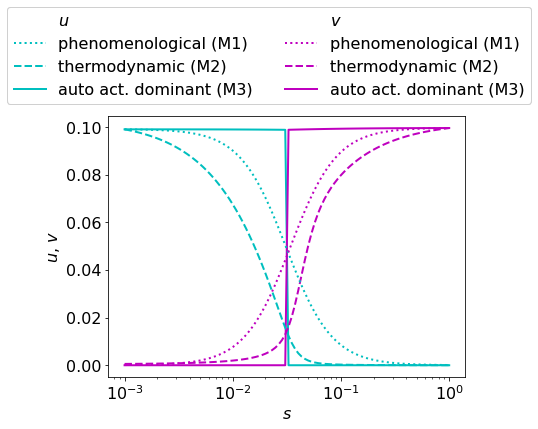

In [50]:
s = np.logspace(-3,0,100)
y = F_auto_act(s)
x_fit = F_thermodynamic(s, *popt1)
x_fit2 = F_phenomenological(s, *popt2)

plt.rcParams['font.size'] = 16
plt.figure(figsize=[6.4, 4.8])
categories = ['phenomenological (M1)', 'thermodynamic (M2)', 'auto act. dominant (M3)']
p5,=plt.plot(s,y[:len(s)], 'c', lw=2)
p6,=plt.plot(s,y[len(s):], 'm', lw=2)
p3,=plt.plot(s,x_fit[:len(s)], 'c', ls='dashed', lw=2)
p4,=plt.plot(s,x_fit[len(s):], 'm', ls='dashed', lw=2)
p1,=plt.plot(s,x_fit2[:len(s)], 'c', ls='dotted', lw=2)
p2,=plt.plot(s,x_fit2[len(s):], 'm', ls='dotted', lw=2)
p7, = plt.plot([0], marker='None',
           linestyle='None', label='dummy-tophead')
plt.xscale('log')
plt.xlabel('$s$')
plt.ylabel('$u$, $v$')

leg = plt.legend([p7, p1, p3, p5, p7, p2, p4, p6],
                 [r'$u$'] + categories + [r'$v$'] + categories,
                 ncol=2,
                 loc='upper center', bbox_to_anchor=(0.45, 1.45))
plt.gca().add_artist(leg)
#plt.savefig('Results/PhD Thesis/Transcription pictures/comparison_signal.png', transparent = True, bbox_extra_artists=(leg,), bbox_inches='tight')
#plt.savefig('Results/PhD Thesis/Transcription pictures/comparison_signal.pdf', transparent = True, bbox_extra_artists=(leg,), bbox_inches='tight')

3.1266793963875443 2.4334769372955454 0.03147142947912975
3.1266793963875443 2.4334769372955454 0.03147142947912975


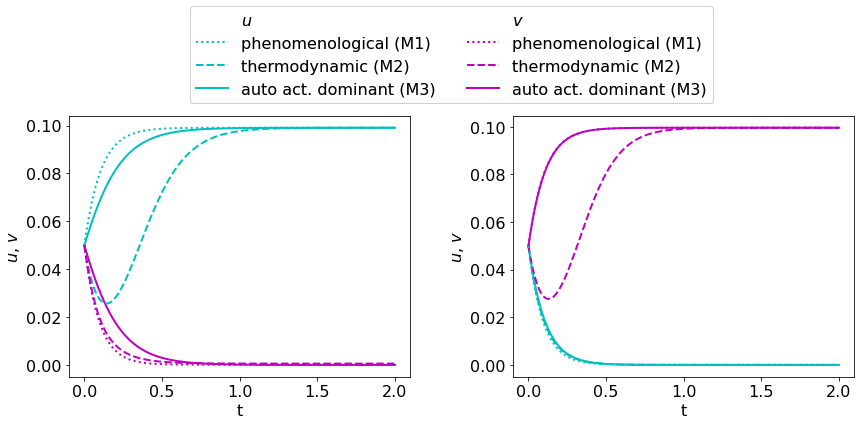

In [46]:
def F_time_auto_act(T, N, s):
    t = np.linspace(0,T,N)
    dt = t[1]-t[0]
    r = 1
    γ = 10

    eta_u = np.exp(7)
    eta_v = np.exp(6)
    eta_s = np.exp(2)
    eta_vs = np.exp(2)

    s_crit = (eta_u - eta_v)/(eta_v*eta_s*eta_vs)
    
    f_u = lambda u, v, s: r*eta_u*u/(1 + eta_u*u + eta_v*v*(1+eta_s*eta_vs*s) + eta_s*s) - γ*u
    f_v = lambda u, v, s: r*eta_v*v*(1+eta_s*eta_vs*s)/(1 + eta_u*u + eta_v*v*(1+eta_s*eta_vs*s) + eta_s*s) - γ*v
    
    u, v = np.empty(N), np.empty(N)
    u[0], v[0] = 0.05, 0.05
    for i in range(N-1):
        u[i+1] = u[i] + dt*f_u(u[i], v[i], s)
        v[i+1] = v[i] + dt*f_v(u[i], v[i], s)

    return t, u, v

def F_time_thermodynamic(T, N, s, r, γ, x, eta_u, eta_v, eta_ux, eta_vx):
    t = np.linspace(0,T,N)
    dt = t[1]-t[0]
    #r, γ = 1, 10
    p = lambda f: x/(f + x)
    
    u0 = p(1)*r/γ
    v0 = p(1)*r/γ
    s0 = (np.exp(7) - np.exp(6))/(np.exp(6)*np.exp(2)*np.exp(2))
    
    eta_s = ((1 + eta_u*eta_ux*v0)/(1 + eta_u*u0)/(1 + eta_v*v0) - 1)/s0
    eta_sx = ((1 + eta_u*u0)*(1 + eta_v*v0)*(1 + eta_s*s0)/(1 + eta_v*eta_vx*v0) - 1)/(eta_s*s0)
    print(np.log(eta_s), np.log(eta_sx), s0)

    f_u = lambda u, v, s: (1 + eta_u*u)*(1 + eta_v*v)*(1 + eta_s*s)/(1 + eta_u*eta_ux*u)
    f_v = lambda u, v, s: (1 + eta_u*u)*(1 + eta_v*v)*(1 + eta_s*s)/(1 + eta_v*eta_vx*v)/(1 + eta_s*eta_sx*s)

    u, v = np.empty(N), np.empty(N)
    u[0], v[0] = 0.05, 0.05
    for i in range(N-1):
        u[i+1] = u[i] + dt*(r*p(f_u(u[i], v[i], s)) - γ*u[i])
        v[i+1] = v[i] + dt*(r*p(f_v(u[i], v[i], s)) - γ*v[i])
        
    return t, u, v

def F_time_phenomenological(T, N, s, r, γ, a_u, a_v, a_s):
    t = np.linspace(0,T,N)
    dt = t[1]-t[0]
    
    n = 2

    f_u = lambda u, v, s: r*(a_u*u**n/(1+a_u*u**n) + 1/(1+a_s*s**n))*1/(1+a_v*v**n) - γ*u
    f_v = lambda u, v, s: r*(a_v*v**n/(1+a_v*v**n) + a_s*s**n/(1+a_s*s**n))*1/(1+a_u*u**n) - γ*v
    
    u, v = np.empty(N), np.empty(N)
    u[0], v[0] = 0.05, 0.05
    for i in range(N-1):
        u[i+1] = u[i] + dt*f_u(u[i], v[i], s)
        v[i+1] = v[i] + dt*f_v(u[i], v[i], s)
        
    return t, u, v


T = 2
N = 1000
s = 1e-3
t, u0, v0 = F_time_auto_act(T, N, s)
t, u1, v1 = F_time_thermodynamic(T, N, s, *popt1)
t, u2, v2 = F_time_phenomenological(T, N, s, *popt2)

plt.rcParams['font.size'] = 16
fig=plt.figure(figsize=[6.4*2.2, 4.8])
plt.subplot(1,2,1)
categories = ['auto act. dominant', 'thermodynamic', 'phenomenological']
p1,=plt.plot(t,u0, 'c', lw=2)
p2,=plt.plot(t,v0, 'm', lw=2)
p3,=plt.plot(t,u1, 'c', ls='dashed', lw=2)
p4,=plt.plot(t,v1, 'm', ls='dashed', lw=2)
p5,=plt.plot(t,u2, 'c', ls='dotted', lw=2)
p6,=plt.plot(t,v2, 'm', ls='dotted', lw=2)
p7, = plt.plot([0], marker='None',
           linestyle='None', label='dummy-tophead')
plt.xlabel('t')
plt.ylabel('$u$, $v$')

s = 1
t, u0, v0 = F_time_auto_act(T, N, s)
t, u1, v1 = F_time_thermodynamic(T, N, s, *popt1)
t, u2, v2 = F_time_phenomenological(T, N, s, *popt2)

plt.subplot(1,2,2)
categories = ['phenomenological (M1)', 'thermodynamic (M2)', 'auto act. dominant (M3)']
p5,=plt.plot(t,u0, 'c', lw=2)
p6,=plt.plot(t,v0, 'm', lw=2)
p3,=plt.plot(t,u1, 'c', ls='dashed', lw=2)
p4,=plt.plot(t,v1, 'm', ls='dashed', lw=2)
p1,=plt.plot(t,u2, 'c', ls='dotted', lw=2)
p2,=plt.plot(t,v2, 'm', ls='dotted', lw=2)
p7, = plt.plot([0], marker='None',
           linestyle='None', label='dummy-tophead')
plt.xlabel('t')
plt.ylabel('$u$, $v$')
fig.subplots_adjust(wspace=0.3)
leg = plt.legend([p7, p1, p3, p5, p7, p2, p4, p6],
                 [r'$u$'] + categories + [r'$v$'] + categories,
                 ncol=2,
                 loc='upper center', bbox_to_anchor=(-.18, 1.45))
plt.gca().add_artist(leg)
#plt.savefig('Results/PhD Thesis/Transcription pictures/comparison_time.png', transparent = True, bbox_inches='tight')
#plt.savefig('Results/PhD Thesis/Transcription pictures/comparison_time.pdf', transparent = True, bbox_inches='tight')

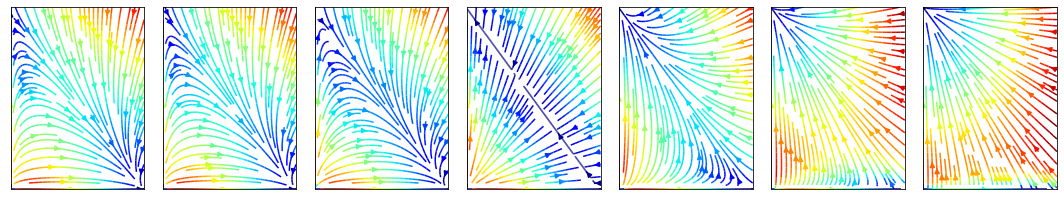

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

X, Y = np.meshgrid(np.linspace(0, .1, 50), np.linspace(0, .1, 50))
u, v = np.zeros_like(X), np.zeros_like(X)
NI, NJ = X.shape

def F_phase_auto_act(X, Y, s):
    r = 1
    γ = 10

    eta_u = np.exp(7)
    eta_v = np.exp(6)
    eta_s = np.exp(2)
    eta_vs = np.exp(2)

    s_crit = (eta_u - eta_v)/(eta_v*eta_s*eta_vs)
    
    f_u = lambda u, v, s: r*eta_u*u/(1 + eta_u*u + eta_v*v*(1+eta_s*eta_vs*s) + eta_s*s) - γ*u
    f_v = lambda u, v, s: r*eta_v*v*(1+eta_s*eta_vs*s)/(1 + eta_u*u + eta_v*v*(1+eta_s*eta_vs*s) + eta_s*s) - γ*v
    
    def F(u, v, s):
        U = f_u(u,v,s)
        V = f_v(u,v,s)

        return U, V
    
    U, V = F(X, Y, s)

    return U, V

def F_phase_thermodynamic(X, Y, s, r, γ, x, eta_u, eta_v, eta_ux, eta_vx):
    #r, γ = 1, 10
    p = lambda f: x/(f + x)
    
    u0 = p(1)*r/γ
    v0 = p(1)*r/γ
    s0 = (np.exp(7) - np.exp(6))/(np.exp(6)*np.exp(2)*np.exp(2))
    
    eta_s = ((1 + eta_u*eta_ux*v0)/(1 + eta_u*u0)/(1 + eta_v*v0) - 1)/s0
    eta_sx = ((1 + eta_u*u0)*(1 + eta_v*v0)*(1 + eta_s*s0)/(1 + eta_v*eta_vx*v0) - 1)/(eta_s*s0)

    f_u = lambda u, v, s: (1 + eta_u*u)*(1 + eta_v*v)*(1 + eta_s*s)/(1 + eta_u*eta_ux*u)
    f_v = lambda u, v, s: (1 + eta_u*u)*(1 + eta_v*v)*(1 + eta_s*s)/(1 + eta_v*eta_vx*v)/(1 + eta_s*eta_sx*s)

    def F(u, v, s):

        U = r*p(f_u(u,v,s)) - γ*u
        V = r*p(f_v(u,v,s)) - γ*v

        return U, V
    
    U, V = F(X, Y, s)
    
    return U, V

def F_phase_phenomenological(X, Y, s, r, γ, a_u, a_v, a_s):
    #r, γ = 1, 10
    n = 2

    f_u = lambda u, v, s: r*(a_u*u**n/(1+a_u*u**n) + 1/(1+a_s*s**n))*1/(1+a_v*v**n) - γ*u
    f_v = lambda u, v, s: r*(a_v*v**n/(1+a_v*v**n) + a_s*s**n/(1+a_s*s**n))*1/(1+a_u*u**n) - γ*v

    def F(u, v, s):
        U = f_u(u,v,s)
        V = f_v(u,v,s)

        return U, V

    U, V = F(X, Y, s)
    
    return U, V

plt.figure(figsize = (15,3))
plt.rc('font', size=14)
nofPlots = 7
for i, s in enumerate(np.logspace(-3,0,nofPlots)):
    plt.subplot(1, nofPlots, i+1)
    U, V = F_phase_auto_act(X,Y,s)
    #U, V = F_phase_thermodynamic(X,Y,s,*popt1)
    #U, V = F_phase_phenomenological(X,Y,s,*popt2)

    #f = lambda x: F_phase_thermodynamic(x[0], x[1], 1,*popt1)
    #sol = fsolve(f, [0.1,0.1])
    #print(sol)
    
    plt.streamplot(X, Y, U, V, color=(U**2 + V**2)**(1/2), density=1, maxlength=10, cmap ='jet')
    #plt.scatter(sol[0], sol[1], color='k', s=100)
    plt.axis([0, .1, 0, .1])
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

### Cell type proportions

In [12]:
import numpy as np

Λ_2D = 0.0245
Λ_3D = 0.0296

n24 = 441.735294117647
n48 = 1041.2380952380954

t24_2D = np.log(n24)/Λ_2D
t24_3D = np.log(n24)/Λ_3D
t48_3D = np.log(n48)/Λ_3D

print(t24_2D, t24_3D, t48_3D)

248.60044165671098 205.76725745234523 234.73532973888538


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from Organoid import Organoid
import pandas as pd

dim = 2
signal = '0.1'

org = Organoid()
s_max = org.r_N/org.gamma_N
upper_boundary = -org.eps_G + np.log(1 + np.exp(-org.eps_S-org.eps_GS)*s_max)
eps_N = np.linspace(-org.eps_G, upper_boundary, 20)
Ratio = np.empty(eps_N.shape)

N0 = org.r_N/org.gamma_N*3/4
G0 = org.r_G/org.gamma_G*3/4

DF = pd.DataFrame()

nofSim = 1
Ratio = np.empty([len(eps_N), nofSim])
for i in range(len(eps_N)):
    print('\ni =', i)
    print('k =', end=' ')
    for k in range(nofSim):
        org = Organoid()

        # Geometry construction
        org.evolution(T = t48_3D, dim=dim, ignore=['transcription'])

        # Transcriptional regulation
        org.eps_N = -eps_N[i]
        org.u = np.append(np.random.normal(N0, N0*0.01, org.nofCells),
                          np.random.normal(G0, G0*0.01, org.nofCells))
        org.N = org.u[:org.nofCells]
        org.G = org.u[org.nofCells:]
        if signal == 'NN':
            org.signal = 'neighbor'
        else:
            org.q = float(signal)
            org.signal = 'dispersion'
        org.evolution(T = 100, dim=dim, ignore=['displacement', 'growth', 'division'])
        F = [1 if org.G[i] >= org.N[i] else 0 for i in range(org.nofCells)]
        Ratio[i,k] = np.sum(F)/org.nofCells
        print(k, end=' ')
        
        df = pd.DataFrame()
        df['ID'] = (i*nofSim + k)*np.ones(org.nofCells, dtype=int)
        df['eps_N'] = eps_N[i]*np.ones(org.nofCells)
        df['x-Position'] = org.pos[:,0]
        df['y-Position'] = org.pos[:,1]
        if dim == 3:
            df['z-Position'] = org.pos[:,2]
        df['Radius'] = org.r
        df['Fate'] = F
        
        DF = DF.append(df)
        
DF.to_csv('Results/PhD Thesis/Cell type proportions/'+str(dim)+'D_'+signal+'.csv', index=False)


i = 0
k = 0 
i = 1
k = 0 
i = 2
k = 0 
i = 3
k = 0 
i = 4
k = 0 
i = 5
k = 0 
i = 6
k = 0 
i = 7
k = 0 
i = 8
k = 0 
i = 9
k = 0 

Organoids have around 314.4485 +/- 45.66029762429905 cells
314.4485 45.66029762429905


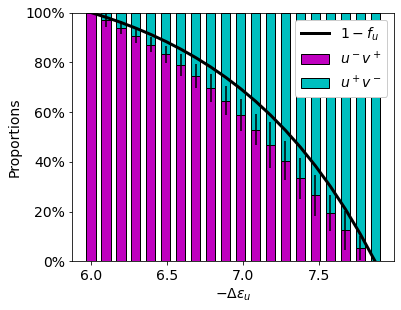

In [167]:
import numpy as np
import matplotlib.pyplot as plt
from Organoid import Organoid
import pandas as pd

dim = 2
signal = '0.9'

η_u = np.exp(-org.eps_N)
η_v = np.exp(-org.eps_G)
η_s = np.exp(-org.eps_GS)
η_vs = np.exp(-org.eps_S)

f = lambda x: 100*10*(np.exp(x) - η_v)/(η_v*η_s*η_vs)

Data = pd.read_csv('Results/PhD Thesis/Cell type proportions/'+str(dim)+'D_'+signal+'.csv')

mean = Data.groupby(['ID', 'eps_N']).mean().reset_index()
std = mean.groupby(['eps_N']).std().reset_index()
prop = mean.groupby(['eps_N']).mean().reset_index()
size = Data.groupby(['ID']).size().reset_index()

print('Organoids have around', size.mean()[0], '+/-', size.std()[0], 'cells')
print(size.mean()[0], size.std()[0])


plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
plt.bar(Data.eps_N.unique(), prop.Fate*100, yerr=std.Fate*1000, 
        width=0.06, color = 'm', edgecolor='k', alpha = 1, label='$u^-v^+$')
plt.bar(Data.eps_N.unique(), (1-prop.Fate)*100, bottom=prop.Fate*100,
        width=0.06, color = 'c', edgecolor='k', alpha = 1, label='$u^+v^-$')
ticks = [0,20,40,60,80,100]
plt.yticks(ticks, [str(x)+'%' for x in ticks])
plt.xlabel('$-\Delta\epsilon_u$')
plt.ylabel('Proportions')
plt.gcf().subplots_adjust(bottom=0.16)
plt.gcf().subplots_adjust(left=0.2)

plt.plot(Data.eps_N.unique(), 100-f(Data.eps_N.unique()), color='k', lw=3, label='$1-f_u$')
plt.legend(framealpha=1, fontsize=14)
plt.ylim([0,100])
plt.savefig('Results/PhD Thesis/Cell type proportions/'+str(dim)+'D_'+signal+'.png', transparent = True)
plt.savefig('Results/PhD Thesis/Cell type proportions/'+str(dim)+'D_'+signal+'.pdf', transparent = True)

In [143]:
max(std.Fate)*100

2.35417800880502

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from Organoid import Organoid
import pandas as pd

dim = 3
signal = 'NN'

Data = pd.read_csv('Results/PhD Thesis/Cell type proportions/'+str(dim)+'D_'+signal+'.csv')

N_mean = 0
N_max = 0
N_min = 100
for ID in Data.ID.unique():
    print(ID, end=' ')
    organoid = Data[Data.ID == ID]
    organoid.to_csv('test.csv', index = False)

    org = Organoid()
    org.nofSteps = 2
    org.evolution(T = 0, file='test.csv', dim=dim, ignore=['division', 'displacement'])

    adjacency = org.GraphDist.copy()
    adjacency[adjacency > 1] = 0
    neighbors = adjacency.sum(1)
    
    N_mean += neighbors.mean()/len(Data.ID.unique())
    N_max = max(neighbors.max(), N_max)
    N_min = min(neighbors.min(), N_min)

print('The '+str(dim)+'D_'+signal+' organoids have a mean of', N_mean, 'neighbors')
print('The '+str(dim)+'D_'+signal+' organoids have a maximum of', N_max, 'neighbors')
print('The '+str(dim)+'D_'+signal+' organoids have a minimum of', N_min, 'neighbors')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

1861 1862 1863 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 The 3D_NN organoids have a mean of 12.801354975267968 neighbors
The 3D_NN organoids have a maximum of 23.0 neighbors
The 3D_NN organoids have a minimum of 1.0 neighbors


### Pattern formation

In [8]:
from Organoid import Organoid
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Λ_3D = 0.0296

n48 = 1041.2380952380954
t48_3D = np.log(n48)/Λ_3D

org = Organoid()
org.evolution(T=t48_3D, dim=2, ignore=['transcription'])
#org.cellPlot(radius='mean')
#org.saveData(directory='Results/PhD pattern/')

200 102 302


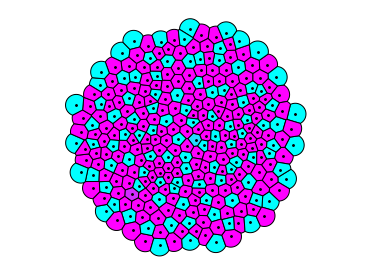

In [71]:
signal = '0.1'

org = Organoid()
org.eps_N = - 6.6
if signal == 'NN':
    org.signal = 'neighbor'
else:
    org.signal = 'dispersion'
    org.q = float(signal)
    
org.nofSteps = 5000
org.evolution(T=500, dim=2, file='Results/PhD pattern/Data.csv', ignore=['division', 'displacement'])
print(len(org.G[org.G > org.N]), org.nofCells-len(org.G[org.G > org.N]), org.nofCells)
plt.figure(figsize=[6.4, 4.8])
org.cellPlot(org.G, radius = 'mean')
#plt.savefig('Results/PhD Thesis/Pattern formation/'+str(signal)+'_eps_u='+str(-org.eps_N)+'.png', transparent = True) 
#plt.savefig('Results/PhD Thesis/Pattern formation/'+str(signal)+'_eps_u='+str(-org.eps_N)+'.pdf', transparent = True)

In [135]:
def pcf(N, G, GraphDist):
    x = np.zeros(len(N))
    x[N > G] = 1
    maxdist = int(np.max(GraphDist))
    ind = np.where(x==1)[0]
    if ind.size == 0:
        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = 0
            
    else:
        dist = GraphDist[ind].T[ind].T
        rho0 = sum(x)/len(x)
        rho1 = (sum(x)-1)/(len(x)-1)


        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = len(dist[dist==i])/len(GraphDist[GraphDist==i])/rho0/rho1

    return P

Pu = []
Pv = []
Tu = []
Tv = []
eps_N_list = []
moran_list = []
eps_N = np.linspace(-6,-7.86,12)
for i in range(10):
    print(i, end=' ')
    org = Organoid()
    org.eps_N = eps_N[i+1]
    org.signal='neighbor'
    org.nofSteps = 1000
    org.evolution(T=100, file = 'Results/PhD pattern/Data.csv', ignore=['division', 'displacement'])
    org.moran()
    
    Tu.append(len(org.N[org.N>org.G]))
    Tv.append(len(org.G[org.G>org.N]))

    Pu.append(pcf(org.N, org.G, org.GraphDist))
    Pv.append(pcf(org.G, org.N, org.GraphDist))
    eps_N_list.append(eps_N)
    moran_list.append(org.Morans_I)

0 1 2 3 4 5 6 7 8 9 

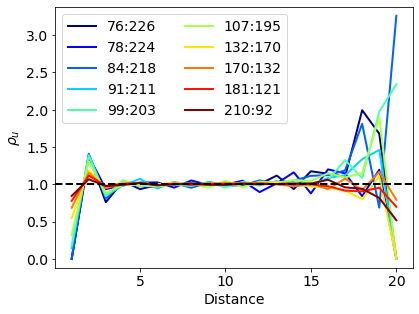

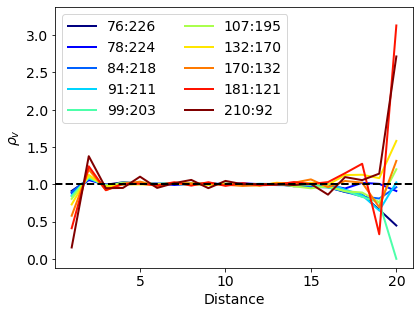

In [137]:
import matplotlib

cmap = matplotlib.cm.get_cmap('jet')
test = np.linspace(0,1,len(Pu))
distances = [j for j in range(1,int(np.max(org.GraphDist))+1)]
plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)

for i in range(len(Pu)):
    rgba = cmap(test[i])
    
    plt.plot(distances,Pu[i], color = rgba, lw=2, label=str(Tu[i])+':'+str(Tv[i]))
    
plt.axhline(1, color='k', ls = 'dashed', lw = 2)
plt.legend(ncol=2)    
plt.xlabel('Distance')
plt.ylabel('$\\rho_u$')
plt.ylim([0-0.12, max([np.max(Pv), np.max(Pu)])+0.12])
plt.savefig('Results/PhD Thesis/Pattern formation/NN_PCF_u.pdf', transparent=True)
plt.savefig('Results/PhD Thesis/Pattern formation/NN_PCF_u.png', transparent=True)

plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
for i in range(len(Pv)):
    rgba = cmap(test[i])
    
    plt.plot(distances,Pv[i], color = rgba, lw=2, label=str(Tu[i])+':'+str(Tv[i]))

plt.axhline(1, color='k', ls = 'dashed', lw = 2)
plt.legend(ncol=2)
plt.xlabel('Distance')
plt.ylabel('$\\rho_v$')
plt.ylim([0-0.12, max([np.max(Pu), np.max(Pv)])+0.12])
#sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=0, vmax=1))
#cbar = plt.colorbar(sm)
#cbar.ax.set_yticklabels([])
#cbar.set_label('$-\Delta\epsilon_g$')
plt.savefig('Results/PhD Thesis/Pattern formation/NN_PCF_v.pdf', transparent=True)
plt.savefig('Results/PhD Thesis/Pattern formation/NN_PCF_v.png', transparent=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Organoid import Organoid
import pandas as pd

signals = ['0.1', '0.5', '0.9']
I = np.empty([100,20,len(signals)])
dim = 3

for k in range(len(signals)):
    signal = signals[k]

    Data = pd.read_csv('Results/PhD Thesis/Cell type proportions/'+str(dim)+'D_'+signal+'.csv')

    for ID in Data.ID.unique():
        if ID % 25 == 0:
            print(ID, end=' ')
            
        organoid = Data[Data.ID == ID]
        organoid.to_csv('test.csv', index = False)

        org = Organoid()
        org.nofSteps = 2
        org.evolution(T = 0, file='test.csv', dim=dim, ignore=['division', 'displacement'])
        org.G = organoid.Fate.to_numpy()
        org.N = 1-org.G

        i = int(ID) % 100
        j = int(int(ID)/100)
        org.moran()
        I[i,j,k] = org.Morans_I

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Organoid import Organoid
import pandas as pd

I = np.empty([100,20,2])

for k in range(2):
    signal = 'NN'
    dim = k+2
    Data = pd.read_csv('Results/PhD Thesis/Cell type proportions/'+str(dim)+'D_'+signal+'.csv')

    for ID in Data.ID.unique():
        if ID % 25 == 0:
            print(ID, end=' ')
            
        organoid = Data[Data.ID == ID]
        organoid.to_csv('test.csv', index = False)

        org = Organoid()
        org.nofSteps = 2
        org.evolution(T = 0, file='test.csv', dim=dim, ignore=['division', 'displacement'])
        org.G = organoid.Fate.to_numpy()
        org.N = 1-org.G

        i = int(ID) % 100
        j = int(int(ID)/100)
        org.moran()
        I[i,j,k] = org.Morans_I

In [ ]:
import matplotlib

cmap = matplotlib.cm.get_cmap('jet')
test = np.linspace(0,1,4)

plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
for k in range(2):
    rgba = list(cmap(test[k+1]))
    rgba[-1] = .3
    p=plt.violinplot(I[:,:,k], positions=Data.eps_N.unique(), widths= 0.075, showextrema=False);

    for pc in p['bodies']:
        pc.set_facecolor(rgba)
        pc.set_edgecolor('black')
        pc.set_alpha(rgba[-1])

    quartile1, medians, quartile3 = np.percentile(I[:,:,k], [25, 50, 75], axis=1)
    plt.hlines(np.median(I[:,:,k], axis=0), Data.eps_N.unique()-.025, Data.eps_N.unique()+.025, color='k')
    
for k in range(2):
    rgba = list(cmap(test[k+1]))
    rgba[-1] = .3
    plt.fill_between([7],[-0.1],[-0.1], color=rgba, label=str(k+2)+'D')
    
plt.legend()
plt.xlabel('$-\Delta\epsilon_u$')
plt.ylabel('Moran\'s I')
plt.tight_layout()
plt.savefig('Results/PhD Thesis/Pattern formation/NN_Morans.pdf', transparent=True)
plt.savefig('Results/PhD Thesis/Pattern formation/NN_Morans.png', transparent=True)

In [ ]:
import matplotlib

cmap = matplotlib.cm.get_cmap('jet')
test = np.linspace(0,1,len(signals)+2)

plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
for k in range(len(signals)):
    rgba = list(cmap(test[k+1]))
    rgba[-1] = .3
    p=plt.violinplot(I[:,:,k], positions=Data.eps_N.unique(), widths= 0.075, showextrema=False);

    for pc in p['bodies']:
        pc.set_facecolor(rgba)
        pc.set_edgecolor('black')
        pc.set_alpha(rgba[-1])

    quartile1, medians, quartile3 = np.percentile(I[:,:,k], [25, 50, 75], axis=1)
    plt.hlines(np.median(I[:,:,k], axis=0), Data.eps_N.unique()-.025, Data.eps_N.unique()+.025, color='k')
    
for k in range(len(signals)):
    rgba = list(cmap(test[k+1]))
    rgba[-1] = .3
    plt.fill_between([7],[0], color=rgba, label='$q = '+str(signals[k])+'$')
    
plt.legend(loc='upper left')
plt.xlabel('$-\Delta\epsilon_u$')
plt.ylabel('Moran\'s I')
#plt.savefig('Results/PhD Thesis/Pattern formation/q_Morans_'+str(dim)+'D.pdf', transparent=True)
#plt.savefig('Results/PhD Thesis/Pattern formation/q_Morans_'+str(dim)+'D.png', transparent=True)

In [91]:
from Organoid import Organoid
import matplotlib.pyplot as plt
import numpy as np

def pcf(N, G, GraphDist):
    x = np.zeros(len(N))
    x[N > G] = 1
    maxdist = int(np.max(GraphDist))
    ind = np.where(x==1)[0]
    if ind.size == 0:
        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = 0
            
    else:
        dist = GraphDist[ind].T[ind].T
        rho0 = sum(x)/len(x)
        rho1 = (sum(x)-1)/(len(x)-1)


        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = len(dist[dist==i])/len(GraphDist[GraphDist==i])/rho0/rho1

    return P

Pu = []
Pv = []
eps_N_list = []
ratio = 151/302
moran_list = []

for i in range(10):
    r = 0
    k = 0
    lower_boundary = -6
    upper_boundary = -7.86
    eps_N = (lower_boundary+upper_boundary)/2
    while r != ratio:
        org = Organoid()
        org.eps_N = eps_N
        org.signal = 'dispersion'
        org.q = 0.1*i
        org.nofSteps=30000
        org.evolution(T=2000, file = 'Results/PhD pattern/Data.csv', ignore=['displacement', 'division'])
        org.moran()
        F = [1 if org.G[i] >= org.N[i] else 0 for i in range(len(org.N))]
        r = sum(F)/len(F)
        k += 1
        print('Iteration: '+str(k)+' Ratio: '+str(r)+' Current eps_N: '+str(eps_N))
        
        if r > ratio:
            lower_boundary = eps_N
        elif r < ratio:
            upper_boundary = eps_N
            
        eps_N = (lower_boundary+upper_boundary)/2

    Pu.append(pcf(org.N, org.G, org.GraphDist))
    Pv.append(pcf(org.G, org.N, org.GraphDist))
    eps_N_list.append(eps_N)
    moran_list.append(org.Morans_I)
    
print('Finished!')

Iteration: 1 Ratio: 0.5099337748344371 Current eps_N: -6.93
Iteration: 2 Ratio: 0.2847682119205298 Current eps_N: -7.395
Iteration: 3 Ratio: 0.3741721854304636 Current eps_N: -7.1625
Iteration: 4 Ratio: 0.5099337748344371 Current eps_N: -7.04625
Iteration: 5 Ratio: 0.5066225165562914 Current eps_N: -7.104374999999999
Iteration: 6 Ratio: 0.37748344370860926 Current eps_N: -7.133437499999999
Iteration: 7 Ratio: 0.37748344370860926 Current eps_N: -7.118906249999999
Iteration: 8 Ratio: 0.37748344370860926 Current eps_N: -7.111640625
Iteration: 9 Ratio: 0.4271523178807947 Current eps_N: -7.1080078124999995
Iteration: 10 Ratio: 0.5099337748344371 Current eps_N: -7.10619140625
Iteration: 11 Ratio: 0.5066225165562914 Current eps_N: -7.107099609375
Iteration: 12 Ratio: 0.49337748344370863 Current eps_N: -7.1075537109375
Iteration: 13 Ratio: 0.5066225165562914 Current eps_N: -7.10732666015625
Iteration: 14 Ratio: 0.5099337748344371 Current eps_N: -7.107440185546875
Iteration: 15 Ratio: 0.5 Curre

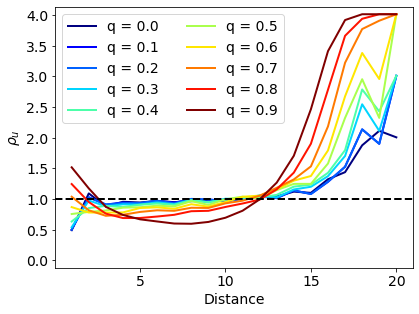

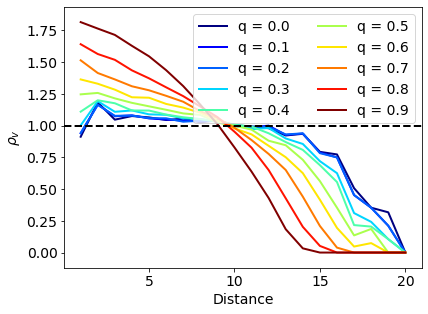

In [98]:
import matplotlib

cmap = matplotlib.cm.get_cmap('jet')
test = np.linspace(0,1,len(Pu))
distances = [j for j in range(1,int(np.max(org.GraphDist))+1)]
plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)

for i in range(len(Pu)):
    rgba = cmap(test[i])
    
    plt.plot(distances,Pu[i], color = rgba, lw=2, label='q = 0.'+str(i))
    
plt.axhline(1, color='k', ls = 'dashed', lw = 2)
plt.legend(ncol=2)    
plt.xlabel('Distance')
plt.ylabel('$\\rho_u$')
plt.ylim([0-0.12, max([np.max(Pu), np.max(Pv)])+0.12])
plt.savefig('Results/PhD Thesis/Pattern formation/q_PCF_u.pdf', transparent=True)
plt.savefig('Results/PhD Thesis/Pattern formation/q_PCF_u.png', transparent=True)

plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
for i in range(len(Pv)):
    rgba = cmap(test[i])
    
    plt.plot(distances,Pv[i], color = rgba, lw=2, label='q = 0.'+str(i))

plt.axhline(1, color='k', ls = 'dashed', lw = 2)
plt.legend(ncol=2, loc='upper right')
plt.xlabel('Distance')
plt.ylabel('$\\rho_v$')
plt.ylim([0-0.12, max([np.max(Pv), np.max(Pv)])+0.12])
#sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=0, vmax=1))
#cbar = plt.colorbar(sm)
#cbar.ax.set_yticklabels([])
#cbar.set_label('$-\Delta\epsilon_g$')
plt.savefig('Results/PhD Thesis/Pattern formation/q_PCF_v.pdf', transparent=True)
plt.savefig('Results/PhD Thesis/Pattern formation/q_PCF_v.png', transparent=True)

### Experimental results

### Cell differentiation timing

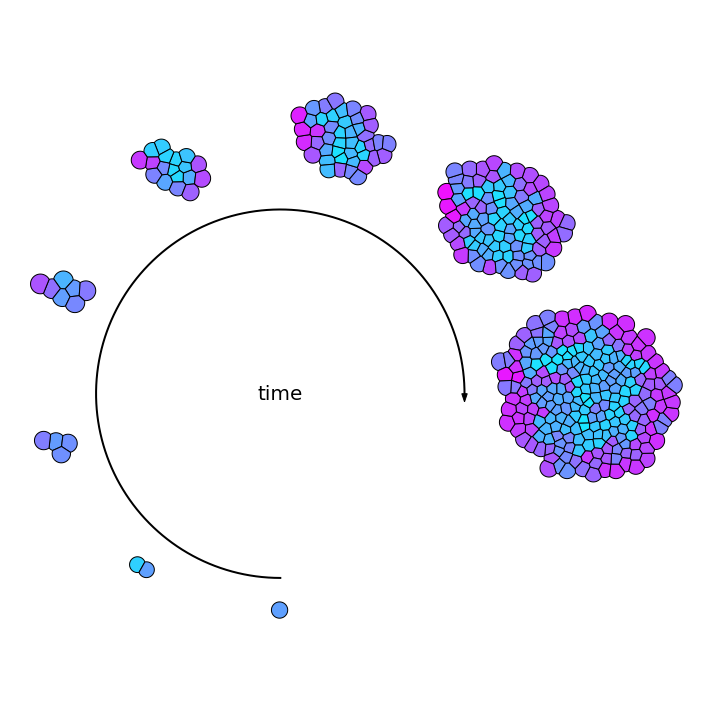

In [17]:
from Organoid import Organoid
import matplotlib.pyplot as plt
import numpy as np

Λ_3D = 0.0296
n48 = 1041.2380952380954
t48_3D = np.log(n48)/Λ_3D

for tau in [0.01,0.05,0.1,1]:
    org = Organoid()
    org.signal = 'dispersion'
    org.q = 0.5
    org.tau = tau
    org.eps_N = -7

    if org.signal == 'neighbor':
        name = 'NN_tau=' + str(org.tau)
    else:
        name = 'q=' + str(org.q) + '_tau=' + str(org.tau)

    org.evolution(T=t48_3D, dim=2)

    # Plot the result
    plt.figure(figsize=(10,10))
    org.circularPlot(TF='GATA6', nofPlots=8, bounds=[0,0.1], radius='mean', size=0)
    plt.tight_layout()
    plt.savefig('Results/PhD Thesis/Cell division/'+name+'.pdf', transparent=True)
    plt.savefig('Results/PhD Thesis/Cell division/'+name+'.png', transparent=True)

### Cell division vs. static Moran's I

#### Division data

In [11]:
from Organoid import Organoid
import numpy as np
import matplotlib.pyplot as plt
import csv

Λ_3D = 0.0296
n48 = 1041.2380952380954
t48_3D = np.log(n48)/Λ_3D

signal = 'NN'
dim = 2

#with open('C:/Users/sis85wc/Desktop/Cell-Differentiation/Results/PhD Thesis/Cell division/'+signal+'_'+str(dim)+'D.csv','w') as f1:
#    writer=csv.writer(f1, delimiter=',',lineterminator='\n',)
#    writer.writerow(['ID', 'x-Position', 'y-Position', 'z-Position', 'Radius', 'N', 'G', 'q'])
#
#    for i in range(1000):
#        org = Organoid()
#        if signal == 'NN':
#            org.signal = 'neighbor'
#        elif signal == 'q':
#            org.signal = 'dispersion'
#            org.q = np.random.uniform(0,1)
#            
#        org.eps_N = -np.random.uniform(6.,7.6)
#        org.evolution(T=t48_3D, dim=dim)
#
#        print('ID =', i, 'Total =', org.nofCells, 'NANOG =', len(org.N[org.N>org.G]), 'GATA6 =', len(org.G[org.G>org.N]), 'q =', org.q)
#
#        for j in range(org.nofCells):
#            if dim == 3:
#                row = [i, org.pos[j,0], org.pos[j,1], org.pos[j,2], org.r[j], org.N[j], org.G[j], org.q]
#            elif dim == 2:
#                row = [i, org.pos[j,0], org.pos[j,1], org.r[j], org.N[j], org.G[j], org.q]
#            writer.writerow(row)

In [223]:
import numpy as np
import matplotlib.pyplot as plt
from Organoid import Organoid
import pandas as pd

I_div = np.empty([100,18,4])
I_sta = np.empty([100,20,4])

dim = 3

signals = ['NN', '0.1', '0.5', '0.9']

for k in range(4):
    signal = signals[k]

    Data_sta = pd.read_csv('Results/PhD Thesis/Cell type proportions/'+str(dim)+'D_'+signal+'.csv')
    Data_div = pd.read_csv('Results/PhD Thesis/Cell division/'+signal+'_'+str(dim)+'D.csv')

    for ID in Data_sta.ID.unique():
            if ID % 25 == 0:
                print(ID, end=' ')

            organoid = Data_sta[Data_sta.ID == ID]
            organoid.to_csv('test.csv', index = False)

            org = Organoid()
            org.nofSteps = 2
            org.evolution(T = 0, file='test.csv', ignore=['division', 'displacement'])
            org.G = organoid.Fate.to_numpy()
            org.N = 1-org.G

            i = int(ID) % 100
            j = int(int(ID)/100)
            org.moran()
            I_sta[i,j,k] = org.Morans_I

    for ID in Data_div.ID.unique():
        if ID % 25 == 0:
            print(ID, end=' ')

        #organoid = Data_div[Data_div.ID == ID]
        #organoid.to_csv('test.csv', index = False)
#
        #org = Organoid()
        #org.nofSteps = 2
        #org.evolution(T = 0, file='test.csv', ignore=['division', 'displacement'])
        #org.G = organoid.G
        #org.N = organoid.N
#
        i = int(ID) % 100
        j = int(int(ID)/100)
        #org.moran()
        #if org.Morans_I != org.Morans_I:
        #    print('ID=', ID)
        I_div[i,j,k] = Data_div[Data_div.ID==ID]["Moran"].to_numpy()[0] #org.Morans_I

0 25 50 75 100 125 150 175 200 225 250 275 300 325 350 375 400 425 450 475 500 525 550 575 600 625 650 675 700 725 750 775 800 825 850 875 900 925 950 975 1000 1025 1050 1075 1100 1125 1150 1175 1200 1225 1250 1275 1300 1325 1350 1375 1400 1425 1450 1475 1500 1525 1550 1575 1600 1625 1650 1675 1700 1725 1750 1775 1800 1825 1850 1875 1900 1925 1950 1975 0 25 50 75 100 125 150 175 200 225 250 275 300 325 350 375 400 425 450 475 500 525 550 575 600 625 650 675 700 725 750 775 800 825 850 875 900 925 950 975 1000 1025 1050 1075 1100 1125 1150 1175 1200 1225 1250 1275 1300 1325 1350 1375 1400 1425 1450 1475 1500 1525 1550 1575 1600 1625 1650 1675 1700 1725 1750 1775 0 25 50 75 100 125 150 175 200 225 250 275 300 325 350 375 400 425 450 475 500 525 550 575 600 625 650 675 700 725 750 775 800 825 850 875 900 925 950 975 1000 1025 1050 1075 1100 1125 1150 1175 1200 1225 1250 1275 1300 1325 1350 1375 1400 1425 1450 1475 1500 1525 1550 1575 1600 1625 1650 1675 1700 1725 1750 1775 1800 1825 1850 

In [220]:
Data_div[Data_div.ID == 1]["Moran"].to_numpy()[0]

0.13750466210238413

In [224]:
def replacenan(I):
    for i in range(I.shape[1]):
        for k in range(I.shape[2]):
            print(np.sum(np.isnan(I[:,i,k])), end=' ')
            I[np.isnan(I[:,i,k]),i] = np.nanmean(I[:,i,k])

    return I

I_div = replacenan(I_div)

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 2 0 0 0 0 0 0 0 0 99 0 0 

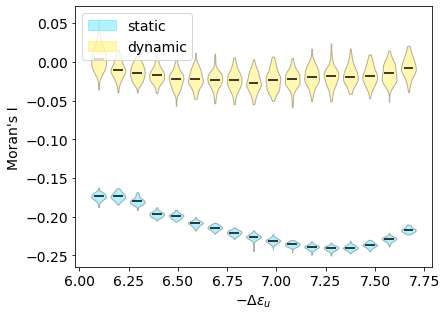

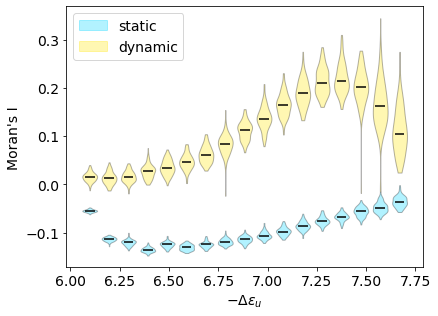

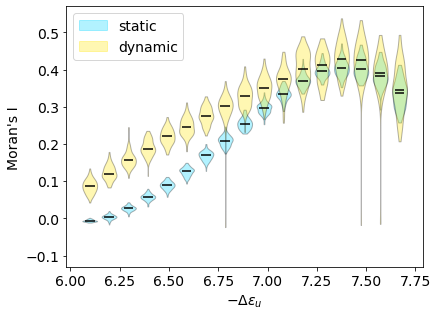

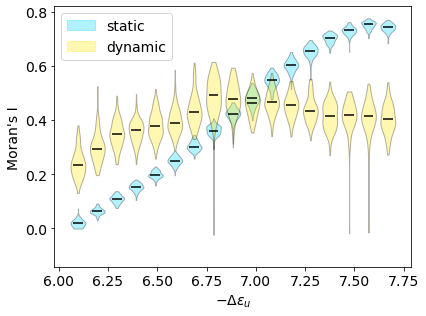

In [227]:
import matplotlib

K = I_sta.shape[2]
cmap = matplotlib.cm.get_cmap('jet')
test = np.linspace(0,1,4)

org = Organoid()
s_max = org.r_N/org.gamma_N
upper_boundary = -org.eps_G + np.log(1 + np.exp(-org.eps_S-org.eps_GS)*s_max)
eps_N = np.linspace(-org.eps_G, upper_boundary, 20)


for k in range(K):
    plt.figure(figsize=[6.4, 4.8])
    plt.rc('font', size=14)

    rgba = list(cmap(test[1]))
    rgba[-1] = .3
    p=plt.violinplot(I_sta[:,1:-2,k], positions=eps_N[1:-2], widths= 0.075, showextrema=False);
    plt.fill_between([7],[-0.1],[-0.1], color=rgba, label='static')
    for pc in p['bodies']:
        pc.set_facecolor(rgba)
        pc.set_edgecolor('black')
        pc.set_alpha(rgba[-1])

    rgba = list(cmap(test[2]))
    rgba[-1] = .3
    p=plt.violinplot(I_div[:,:-1,k], positions=eps_N[1:-2], widths= 0.075, showextrema=False);
    plt.fill_between([7],[-0.1],[-0.1], color=rgba, label='dynamic')
    for pc in p['bodies']:
        pc.set_facecolor(rgba)
        pc.set_edgecolor('black')
        pc.set_alpha(rgba[-1])

    plt.hlines(np.median(I_sta[:,1:-2,k], axis=0), eps_N[1:-1]-.025, eps_N[1:-1]+.025, color='k')

    plt.hlines(np.median(I_div[:,:-1,k], axis=0), eps_N[1:-1]-.025, eps_N[1:-1]+.025, color='k')
    
    plt.legend(loc='upper left')
    plt.xlabel('$-\Delta\epsilon_u$')
    plt.ylabel('Moran\'s I')

    plt.savefig('Results/PhD Thesis/Cell division/'+signals[k]+'_'+str(dim)+'D_Morans.pdf', transparent=True)
    plt.savefig('Results/PhD Thesis/Cell division/'+signals[k]+'_'+str(dim)+'D_Morans.png', transparent=True)

### Cell division vs static pattern formation

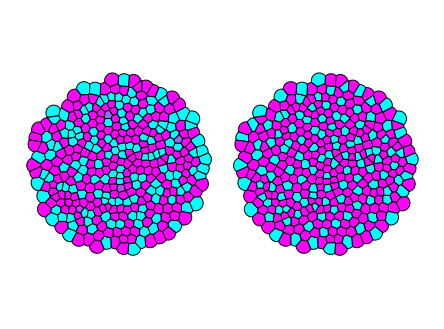

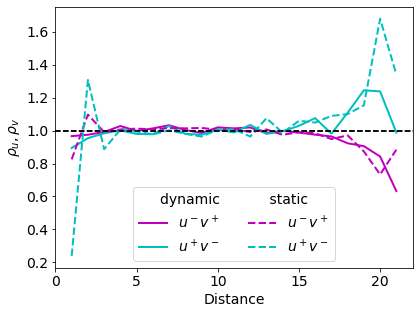

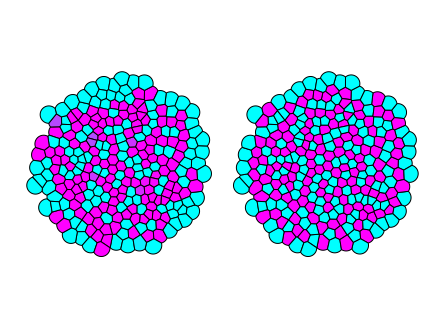

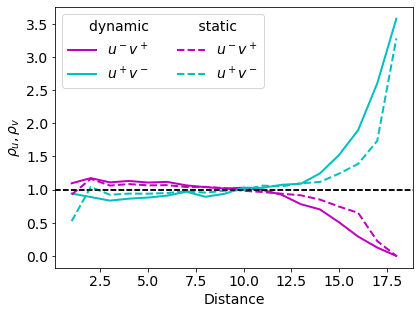

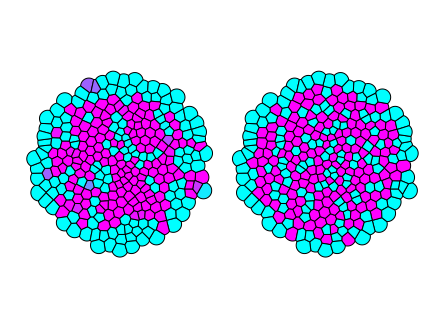

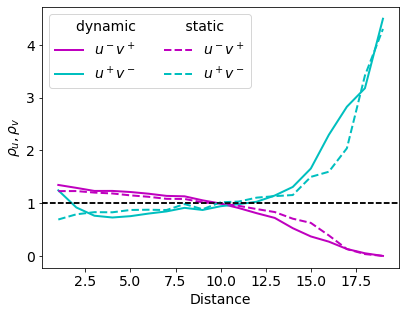

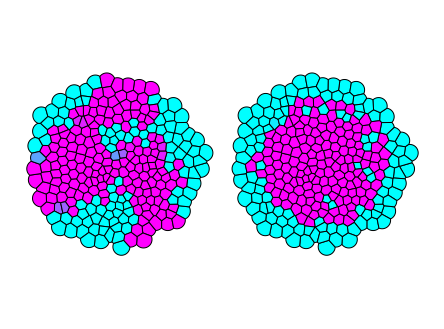

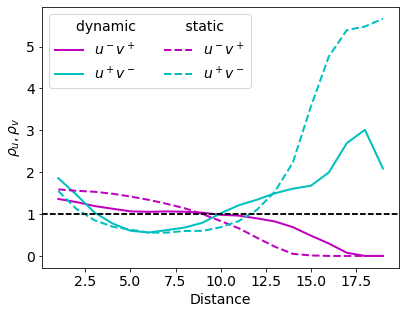

In [10]:
from Organoid import Organoid
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Λ_3D = 0.0296
n48 = 1041.2380952380954
t48_3D = np.log(n48)/Λ_3D

signals = ['NN', '0.1', '0.5', '0.9']

for i in range(len(signals)):
    plt.figure(figsize=[6.4, 4.8])
    org1 = Organoid()
    org1.nofSteps = 10000
    if signals[i] == 'NN':
        org1.signal = 'neighbor'
    else:
        org1.signal = 'dispersion'
        org1.q = float(signals[i])
    org1.eps_N = -7
    org1.evolution(T=np.log(n48)/Λ_3D)
    org1.saveData(directory='Results/Cell Fate/', plot=False)

    org2 = Organoid()
    org2.nofSteps = 10000
    if signals[i] == 'NN':
        org2.signal = 'neighbor'
    else:
        org2.signal = 'dispersion'
        org2.q = float(signals[i])
    org2.eps_N = -7
    org2.evolution(T=1000, file = 'Results/Cell Fate/Data.csv', ignore=['division', 'displacement'])
    
    
    
    dist = np.max(org1.dist)
    org2.pos += np.array([dist*1.2,0])
    org1.cellPlot(org1.G, size=0, radius='mean')
    org2.cellPlot(org2.G, size=0, radius='mean')
    plt.tight_layout()
    
    plt.savefig('Results/PhD Thesis/Cell division/'+signals[i]+'_static_vs_division.pdf', transparent=True)
    plt.savefig('Results/PhD Thesis/Cell division/'+signals[i]+'_static_vs_division.png', transparent=True)
    
    plt.figure(figsize=[6.4, 4.8])
    org1.pcf()
    org2.pcf(ls='dashed')
    plt.legend(['$u^-v^+$', '$u^+v^-$', '$u^-v^+$', '$u^+v^-$'], title = 'dynamic           static', ncol=2)
    
    plt.savefig('Results/PhD Thesis/Cell division/'+signals[i]+'_static_vs_division_PCF.pdf', transparent=True)
    plt.savefig('Results/PhD Thesis/Cell division/'+signals[i]+'_static_vs_division_PCF.png', transparent=True)

In [8]:
org2.G.max()

2559.3767369740863

### Cell division - number of divisions quantification

In [2]:
from Organoid import Organoid
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Λ_2D = 0.0245
Λ_3D = 0.0296
n48 = 1041.2380952380954
t48_3D = np.log(n48)/Λ_3D

t_div_2D = np.log(2)/Λ_2D
t_div_3D = np.log(2)/Λ_3D

-0.07634984381972335
-0.1170208897897679
-0.07745132470195648
-0.15584682396342495


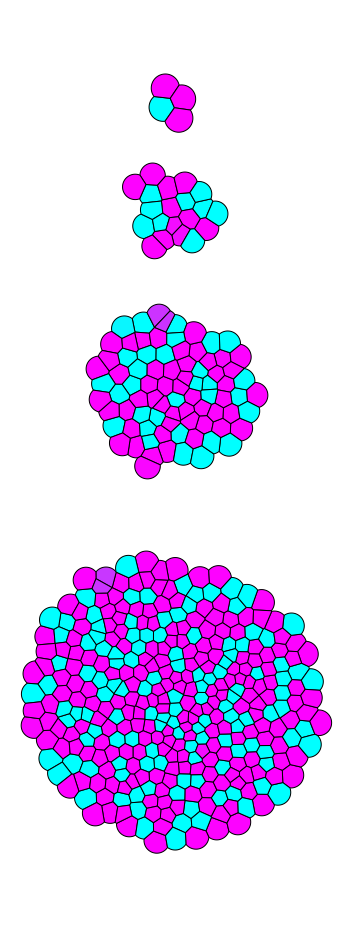

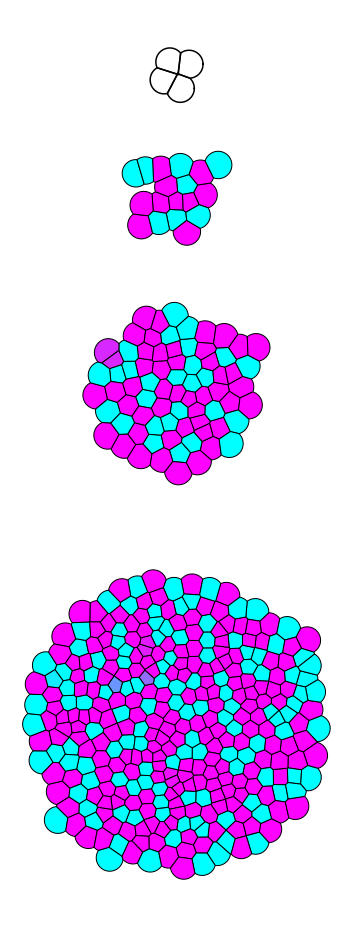

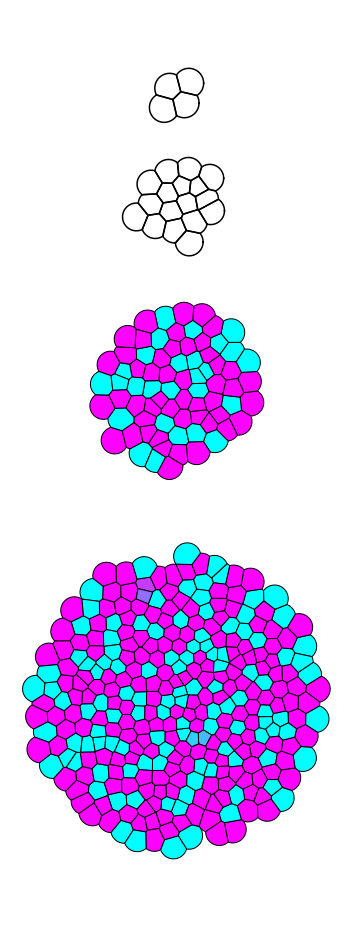

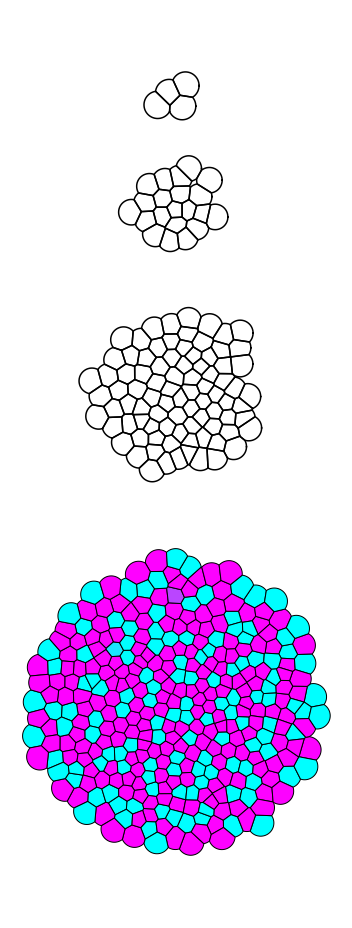

In [85]:
dim = 2
if dim == 2:
    t_div = np.log(2)/Λ_2D
elif dim == 3:
    t_div = np.log(2)/Λ_3D

t0 = t48_3D - int(t48_3D/t_div)*t_div

nofTimes = 4
k = np.unique(np.linspace(0, int(t48_3D/t_div), nofTimes+1, dtype=int))

for i in range(nofTimes):
    nofTimes = 4
    k = np.unique(np.linspace(0, int(t48_3D/t_div), nofTimes+1, dtype=int))

    plt.figure(figsize=(5,13))
    org = Organoid()
    org.eps_N = -7
    org.signal = 'neighbor'
    org.q = 0.5
    org.evolution(T=t0, dim=dim, ignore=['transcription'])

    N0 = org.r_N/org.gamma_N*3/4
    G0 = org.r_G/org.gamma_G*3/4
    org.u = np.append(np.random.normal(N0, N0*0.01, org.nofCells),
                       np.random.normal(G0, G0*0.01, org.nofCells))
    org.N = org.u[:org.nofCells]
    org.G = org.u[org.nofCells:]

    for j in range(nofTimes):
        if i > j:
            ignore=['transcription']
        else:
            ignore=[]

        org.evolution(T=(k[j+1]-k[j])*t_div, dim=dim, ignore=ignore)
        org.pos -= np.array([0,np.max(org.dist)+1.5])

        if i > j:
            N0 = org.r_N/org.gamma_N*3/4
            G0 = org.r_G/org.gamma_G*3/4
            org.u = np.append(np.random.normal(N0, N0*0.01, org.nofCells),
                               np.random.normal(G0, G0*0.01, org.nofCells))
            org.N = org.u[:org.nofCells]
            org.G = org.u[org.nofCells:]

            org.cellPlot(bounds=[0,0.1], size=0, radius='mean') 
        else:
            org.cellPlot(org.G, bounds=[0,0.1], size=0, radius='mean') 

    #lims = 11
    #plt.xlim([-lims,lims])
    plt.tight_layout()
    plt.savefig('Results/PhD Thesis/Cell division/division_number_pattern_NN_'+str(i)+'.pdf', transparent=True)
    plt.savefig('Results/PhD Thesis/Cell division/division_number_pattern_NN_'+str(i)+'.png', transparent=True)
    org.moran()
    print(org.Morans_I)

In [ ]:
dim = 2
signal = '0.9'
if dim == 2:
    t_div = np.log(2)/Λ_2D
elif dim == 3:
    t_div = np.log(2)/Λ_3D

t0 = t48_3D - int(t48_3D/t_div)*t_div

t = np.linspace(0, t48_3D-t0, int(t48_3D/t_div)+1)

DF = pd.DataFrame()
nofSim = 100
for i in range(len(t)-1):
    print('\ni =', i)
    print('j =', end=' ')
    for j in range(nofSim):
        print(j, end=' ')
        org = Organoid()
        org.eps_N = np.random.uniform(-6.5, -7.5)
        if signal == 'NN':
            org.signal = 'neighbor'
        else:
            org.signal = 'dispersion'
            org.q = float(signal)
            
        Steps0 = int(5000*(t0+t[i])/t[-1])
        Steps1 = int(5000*(t[-1]-(t0+t[i]))/t[-1])
        
        org.nofSteps = Steps0
        org.evolution(T=t0+t[i], dim=dim, ignore=['transcription'])
        N0 = org.r_N/org.gamma_N*3/4
        G0 = org.r_G/org.gamma_G*3/4
        org.u = np.append(np.random.normal(N0, N0*0.01, org.nofCells),
                           np.random.normal(G0, G0*0.01, org.nofCells))
        org.N = org.u[:org.nofCells]
        org.G = org.u[org.nofCells:]
        org.nofSteps = Steps1
        org.evolution(T=t[-1]-(t0+t[i]), dim=dim)
        org.moran()
        
        df = pd.DataFrame()
        df['ID'] = (j*(len(t)-1) + i)*np.ones(org.nofCells, dtype=int)
        df['x-Position'] = org.pos[:,0]
        df['y-Position'] = org.pos[:,1]
        if dim == 3:
            df['z-Position'] = org.pos[:,2]
        df['Radius'] = org.r
        df['N'] = org.N
        df['G'] = org.G
        df['eps_N'] = org.eps_N*np.ones(org.nofCells)
        df['t_start'] = t0 + t[i]
        df['Moran'] = org.Morans_I
        
        DF = DF.append(df)
        
DF.to_csv('Results/PhD Thesis/Cell division/division_number_'+signal+'_'+str(dim)+'D.csv', index=False)

In [96]:
t = np.linspace(t0, t48_3D, int(t48_3D/t_div))
t_div, t[0]+t_div, t

(28.29172165550797,
 36.69327815032959,
 array([  8.40155649,  40.73495267,  73.06834885, 105.40174503,
        137.73514121, 170.06853738, 202.40193356, 234.73532974]))

In [89]:
int(t48_3D/t_div)

8

In [88]:
t = np.linspace(0, t48_3D-t0, int(t48_3D/t_div)+1)
t

array([  0.        ,  32.33339618,  64.66679236,  97.00018853,
       129.33358471, 161.66698089, 194.00037707, 226.33377324])

In [109]:
DF1_2D = pd.read_csv('Results/PhD Thesis/Cell division/division_number_NN_2D.csv')
DF2_2D = pd.read_csv('Results/PhD Thesis/Cell division/division_number_0.1_2D.csv')
DF3_2D = pd.read_csv('Results/PhD Thesis/Cell division/division_number_0.5_2D.csv')
DF4_2D = pd.read_csv('Results/PhD Thesis/Cell division/division_number_0.9_2D.csv')

DF1_3D = pd.read_csv('Results/PhD Thesis/Cell division/division_number_NN_3D.csv')
DF2_3D = pd.read_csv('Results/PhD Thesis/Cell division/division_number_0.1_3D.csv')
DF3_3D = pd.read_csv('Results/PhD Thesis/Cell division/division_number_0.5_3D.csv')
DF4_3D = pd.read_csv('Results/PhD Thesis/Cell division/division_number_0.9_3D.csv')

In [110]:
def add_ratio(df):
    ratio = []
    for ID in df.ID.unique():
        test = df[df.ID == ID]
        r = len(test[test.N > test.G])/len(test[test.N <= test.G])
        ratio += [r]*len(test)

    df['ratio'] = ratio
    return df

DF1_2D = add_ratio(DF1_2D)
DF2_2D = add_ratio(DF2_2D)
DF3_2D = add_ratio(DF3_2D)
DF4_2D = add_ratio(DF4_2D)

DF1_3D = add_ratio(DF1_3D)
DF2_3D = add_ratio(DF2_3D)
DF3_3D = add_ratio(DF3_3D)
DF4_3D = add_ratio(DF4_3D)

In [111]:
def exclude_ratios(df):
    new_df = df[(df.ratio > 0.5) & (df.ratio < 2)]
    
    return new_df

before = [len(DF1_2D), len(DF2_2D), len(DF3_2D), len(DF4_2D)]
DF1_2D = exclude_ratios(DF1_2D)
DF2_2D = exclude_ratios(DF2_2D)
DF3_2D = exclude_ratios(DF3_2D)
DF4_2D = exclude_ratios(DF4_2D)
after = [len(DF1_2D), len(DF2_2D), len(DF3_2D), len(DF4_2D)]

print(np.array(after)/np.array(before))

before = [len(DF1_3D), len(DF2_3D), len(DF3_3D), len(DF4_3D)]
DF1_3D = exclude_ratios(DF1_3D)
DF2_3D = exclude_ratios(DF2_3D)
DF3_3D = exclude_ratios(DF3_3D)
DF4_3D = exclude_ratios(DF4_3D)
after = [len(DF1_3D), len(DF2_3D), len(DF3_3D), len(DF4_3D)]

print(np.array(after)/np.array(before))

[0.62915251 0.53014074 0.49470469 0.5321477 ]
[0.54842274 0.47016811 0.49012778 0.49411965]


In [56]:
[1-0.62915251, 1-0.53014074, 1-0.49470469, 1-0.5321477 ],[1-0.54842274, 1-0.47016811, 1-0.49012778, 1-0.49411965]

([0.37084748999999995, 0.46985926, 0.5052953099999999, 0.4678523],
 [0.45157726, 0.5298318900000001, 0.50987222, 0.50588035])

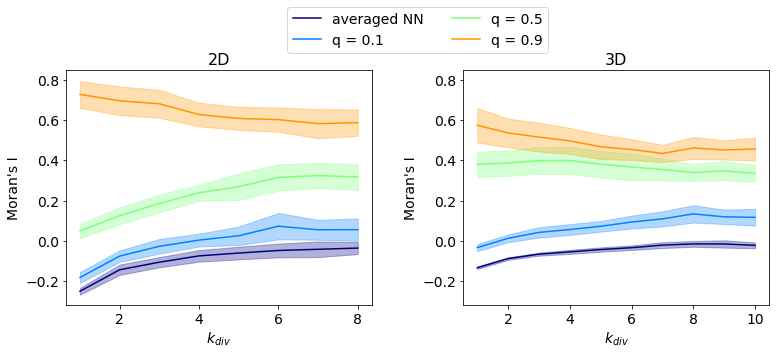

In [123]:
import matplotlib

plt.figure(figsize=[11, 5.4])

plt.subplot(121)
cmap = matplotlib.cm.get_cmap('jet')
test = np.linspace(0,1,5)

rgba = list(cmap(test[0]))
rgba[-1] = .3

#M1_mean = DF1.groupby(['t_start']).mean().reset_index()['Moran'][::-1]
M1_mean = DF1_2D.groupby(['ID', 't_start']).nth(0).reset_index().groupby('t_start').mean().reset_index().Moran[::-1]
M2_mean = DF2_2D.groupby(['ID', 't_start']).nth(0).reset_index().groupby('t_start').mean().reset_index().Moran[::-1]
M3_mean = DF3_2D.groupby(['ID', 't_start']).nth(0).reset_index().groupby('t_start').mean().reset_index().Moran[::-1]
M4_mean = DF4_2D.groupby(['ID', 't_start']).nth(0).reset_index().groupby('t_start').mean().reset_index().Moran[::-1]

M1_std = DF1_2D.groupby(['ID', 't_start']).nth(0).reset_index().groupby('t_start').std().reset_index().Moran[::-1]
M2_std = DF2_2D.groupby(['ID', 't_start']).nth(0).reset_index().groupby('t_start').std().reset_index().Moran[::-1]
M3_std = DF3_2D.groupby(['ID', 't_start']).nth(0).reset_index().groupby('t_start').std().reset_index().Moran[::-1]
M4_std = DF4_2D.groupby(['ID', 't_start']).nth(0).reset_index().groupby('t_start').std().reset_index().Moran[::-1]

div_num = list(range(1,len(M1_mean)+1))

plt.rc('font', size=14)
plt.plot(div_num, M1_mean, color=list(cmap(test[0])), label='averaged NN')
plt.plot(div_num, M2_mean, color=list(cmap(test[1])), label='q = 0.1')
plt.plot(div_num, M3_mean, color=list(cmap(test[2])), label='q = 0.5')
plt.plot(div_num, M4_mean, color=list(cmap(test[3])), label='q = 0.9')

plt.fill_between(div_num, M1_mean-M1_std, M1_mean+M1_std, color=list(cmap(test[0])), alpha = 0.3)
plt.fill_between(div_num, M2_mean-M2_std, M2_mean+M2_std, color=list(cmap(test[1])), alpha = 0.3)
plt.fill_between(div_num, M3_mean-M3_std, M3_mean+M3_std, color=list(cmap(test[2])), alpha = 0.3)
plt.fill_between(div_num, M4_mean-M4_std, M4_mean+M4_std, color=list(cmap(test[3])), alpha = 0.3)

plt.xlabel('$k_{div}$')
plt.ylabel('Moran\'s I')
plt.legend(loc='upper center', bbox_to_anchor=(1.15, 1.3), ncol=2)
plt.title('2D', fontsize=16)
y1, y2 = plt.ylim()

plt.subplot(122)
cmap = matplotlib.cm.get_cmap('jet')
test = np.linspace(0,1,5)

rgba = list(cmap(test[0]))
rgba[-1] = .3

#M1_mean = DF1.groupby(['t_start']).mean().reset_index()['Moran'][::-1]
M1_mean = DF1_3D.groupby(['ID', 't_start']).nth(0).reset_index().groupby('t_start').mean().reset_index().Moran[::-1]
M2_mean = DF2_3D.groupby(['ID', 't_start']).nth(0).reset_index().groupby('t_start').mean().reset_index().Moran[::-1]
M3_mean = DF3_3D.groupby(['ID', 't_start']).nth(0).reset_index().groupby('t_start').mean().reset_index().Moran[::-1]
M4_mean = DF4_3D.groupby(['ID', 't_start']).nth(0).reset_index().groupby('t_start').mean().reset_index().Moran[::-1]

M1_std = DF1_3D.groupby(['ID', 't_start']).nth(0).reset_index().groupby('t_start').std().reset_index().Moran[::-1]
M2_std = DF2_3D.groupby(['ID', 't_start']).nth(0).reset_index().groupby('t_start').std().reset_index().Moran[::-1]
M3_std = DF3_3D.groupby(['ID', 't_start']).nth(0).reset_index().groupby('t_start').std().reset_index().Moran[::-1]
M4_std = DF4_3D.groupby(['ID', 't_start']).nth(0).reset_index().groupby('t_start').std().reset_index().Moran[::-1]

div_num = list(range(1,len(M1_mean)+1))

plt.rc('font', size=14)
plt.plot(div_num, M1_mean, color=list(cmap(test[0])), label='averaged NN')
plt.plot(div_num, M2_mean, color=list(cmap(test[1])), label='q = 0.1')
plt.plot(div_num, M3_mean, color=list(cmap(test[2])), label='q = 0.5')
plt.plot(div_num, M4_mean, color=list(cmap(test[3])), label='q = 0.9')

plt.fill_between(div_num, M1_mean-M1_std, M1_mean+M1_std, color=list(cmap(test[0])), alpha = 0.3)
plt.fill_between(div_num, M2_mean-M2_std, M2_mean+M2_std, color=list(cmap(test[1])), alpha = 0.3)
plt.fill_between(div_num, M3_mean-M3_std, M3_mean+M3_std, color=list(cmap(test[2])), alpha = 0.3)
plt.fill_between(div_num, M4_mean-M4_std, M4_mean+M4_std, color=list(cmap(test[3])), alpha = 0.3)

plt.xlabel('$k_{div}$')
plt.ylabel('Moran\'s I')
plt.title('3D', fontsize=16)
plt.ylim([y1, y2])

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.savefig("Results/PhD Thesis/Cell division/div_number_quantification.pdf", transparent=True)
plt.savefig("Results/PhD Thesis/Cell division/div_number_quantification.png", transparent=True)

In [129]:
r = 0.25/10.09
print(7.86*r, 9.01*r)
print(6.15*r, 10.09*r)

0.19474727452923687 0.2232408325074331
0.15237859266600595 0.25


In [163]:
DF1.groupby(['ID', 't_start']).nth(0).reset_index().groupby('t_start').mean().Moran[::-1]

t_start
206.443608   -0.249972
178.151886   -0.143349
149.860165   -0.105651
121.568443   -0.074452
93.276721    -0.060282
64.985000    -0.047538
36.693278    -0.041648
8.401556     -0.035606
Name: Moran, dtype: float64

In [166]:
DF1.groupby(['t_start']).mean().reset_index()['Moran'][::-1]

7   -0.249895
6   -0.143571
5   -0.105297
4   -0.074326
3   -0.060932
2   -0.048747
1   -0.042081
0   -0.035679
Name: Moran, dtype: float64

In [145]:
DF1

ID  x-Position  y-Position    Radius             N             G  \
0         0   -1.068602    7.916214  0.882490  9.910659e-02  5.709208e-79   
1         0   -0.206202   -5.265033  0.985763  3.713055e-28  9.908704e-02   
2         0   -5.075094   -0.513475  0.812093  6.572251e-34  9.908667e-02   
3         0    3.747420   -0.856444  0.875323  9.936691e-02  3.944151e-34   
4         0    6.198427    2.958781  0.896346  9.929890e-02  3.037359e-38   
...     ...         ...         ...       ...           ...           ...   
201590  799   -2.707965    5.408186  0.684581  1.784284e-17  9.890015e-02   
201591  799    1.674953    6.963825  0.685841  5.216108e-17  9.908387e-02   
201592  799    2.224746   -6.933295  0.654324  1.623459e-17  9.869058e-02   
201593  799    4.490204   -5.145527  0.671183  9.899149e-02  2.170631e-31   
201594  799   -5.872628   -1.899615  0.651043  9.417173e-13  7.171421e-02   

           eps_N     t_start     Moran     ratio  
0      -7.481592    8.401556 -0.016964  1.612245  
1      -7.481592    8.401556 -0.016964  1.612245  
2      -7.481592    8.401556 -0.016964  1.612245  
3      -7.481592    8.401556 -0.016964  1.612245  
4      -7.481592    8.401556 -0.016964  1.612245  
...          ...         ...       ...       ...  
201590 -7.157842  206.443608 -0.276719  0.772414  
201591 -7.157842  206.443608 -0.276719  0.772414  
201592 -7.157842  206.443608 -0.276719  0.772414  
201593 -7.157842  206.443608 -0.276719  0.772414  
201594 -7.157842  206.443608 -0.276719  0.772414  

[126834 rows x 10 columns]

### Experimental data

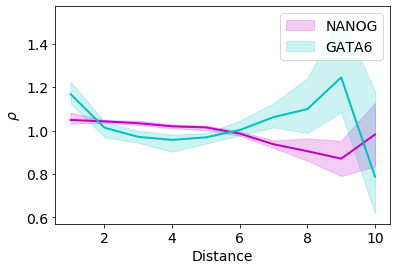

In [59]:
from ExpData import ExpData

dat = ExpData('Data/includingSurfaceDistance/extendedRawDataICMOrganoids.csv')
dat.pcf_bounds(1, 10)

In [154]:
IDs = list(range(1,77))
IDs_24 = []
IDs_48 = []
for ID in IDs:
    if dat.info(ID, output=True)[0] == '24h':
        IDs_24.append(ID)
    if dat.info(ID, output=True)[0] == '48h':
        IDs_48.append(ID)

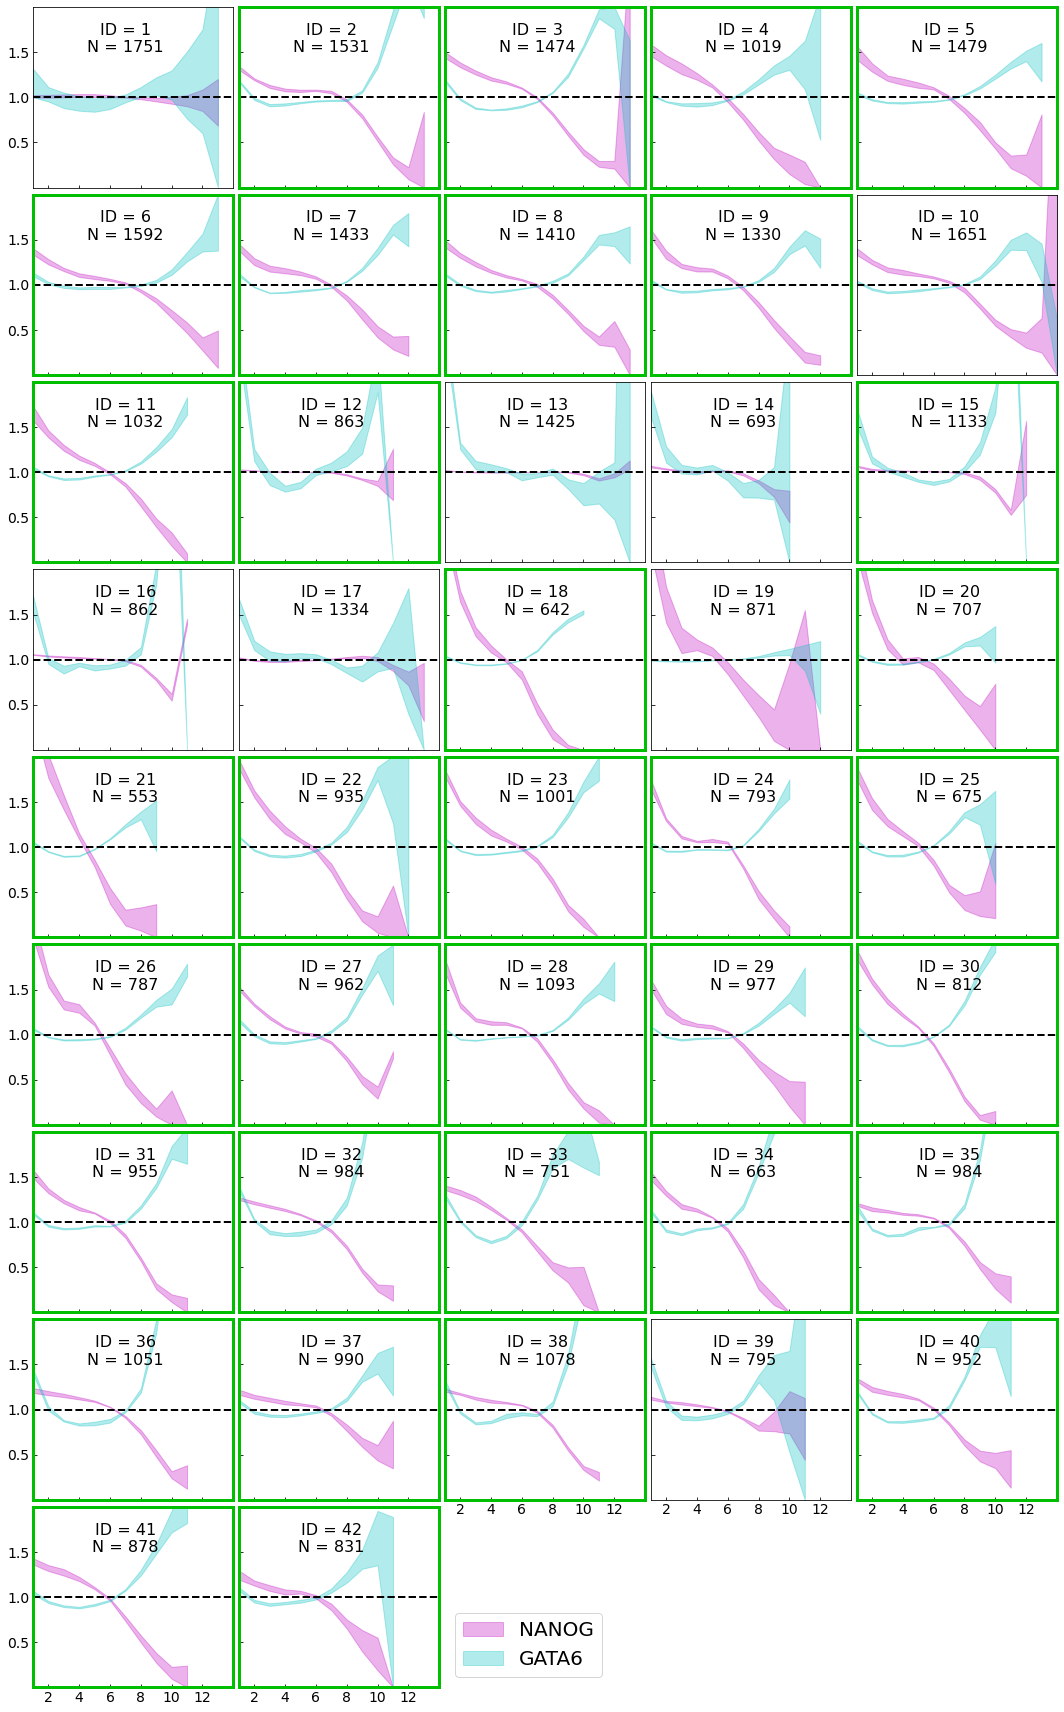

In [188]:
maxlen = 0
maxval = 0
for ID in IDs_48:
    dat.pcf_bounds(ID, 1000, plot=False)
    if len(dat.pcf[ID][0]) > maxlen:
        maxlen = len(dat.pcf[ID][0])
    if dat.pcf[ID].max() > maxval:
        maxval = dat.pcf[ID].max()

dist = list(range(1,maxlen+1))

m = 5
n = int(len(IDs_48)/m)+1
bad = [1,10,13,14,16,17,19,39,]
plt.figure(figsize=(3*m,3*n-3))
plt.rc('font', size=14)
for i, ID in enumerate(IDs_48+[1000]):
    
    if ID == 1000:
        N0, G0 = [0], [0]
        N1, G1 = [0], [0]
        
    else:
        N0 = dat.pcf[ID][0]
        N1 = dat.pcf[ID][2]

        G0 = dat.pcf[ID][3]
        G1 = dat.pcf[ID][5]
    
    dist = list(range(1,len(N0)+1))
    plt.subplot(n, m, i+1)
    plt.fill_between(dist, N0, N1, color='m', alpha=0.3)
    plt.fill_between(dist, G0, G1, color='c', alpha=0.3)
    plt.xlim([1,maxlen])
    plt.ylim([0,2])
    if (i % m) == 0:
        plt.yticks([.5,1,1.5])
    else:
        plt.yticks([.5,1,1.5], labels=[])
        
    if i >= len(IDs_48)-m:
         plt.xticks(np.arange(2, maxlen, 2.0))
    else:
         plt.xticks(np.arange(2, maxlen, 2.0), labels=[])
    if ID == 1000:
        plt.legend(['NANOG', 'GATA6'], fontsize=20, loc='lower left')
        plt.axis('off')
    else:
        plt.text(maxlen/2, 1.5, 'ID = '+str(i+1)+'\nN = '+str(dat.info(ID, output=True)[1]), fontsize=16, ha='center')
        plt.axhline(1, lw=2, linestyle='dashed', color='k')
       
    if i+1 not in bad:
        ax = plt.gca()
        plt.setp(ax.spines.values(), linewidth=3, color=[0,.75,0,1])
    #else:
    #    ax = plt.gca()
    #    plt.setp(ax.spines.values(), linewidth=3, color=[.75,0,0,1])
    plt.tick_params(direction="in")

#plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.tight_layout(h_pad=-.75, w_pad=-.5)
plt.savefig('Results/PhD Thesis/Exp data/48h.pdf', transparent=True, layout='tight')
plt.savefig('Results/PhD Thesis/Exp data/48h.png', transparent=True, layout='tight')

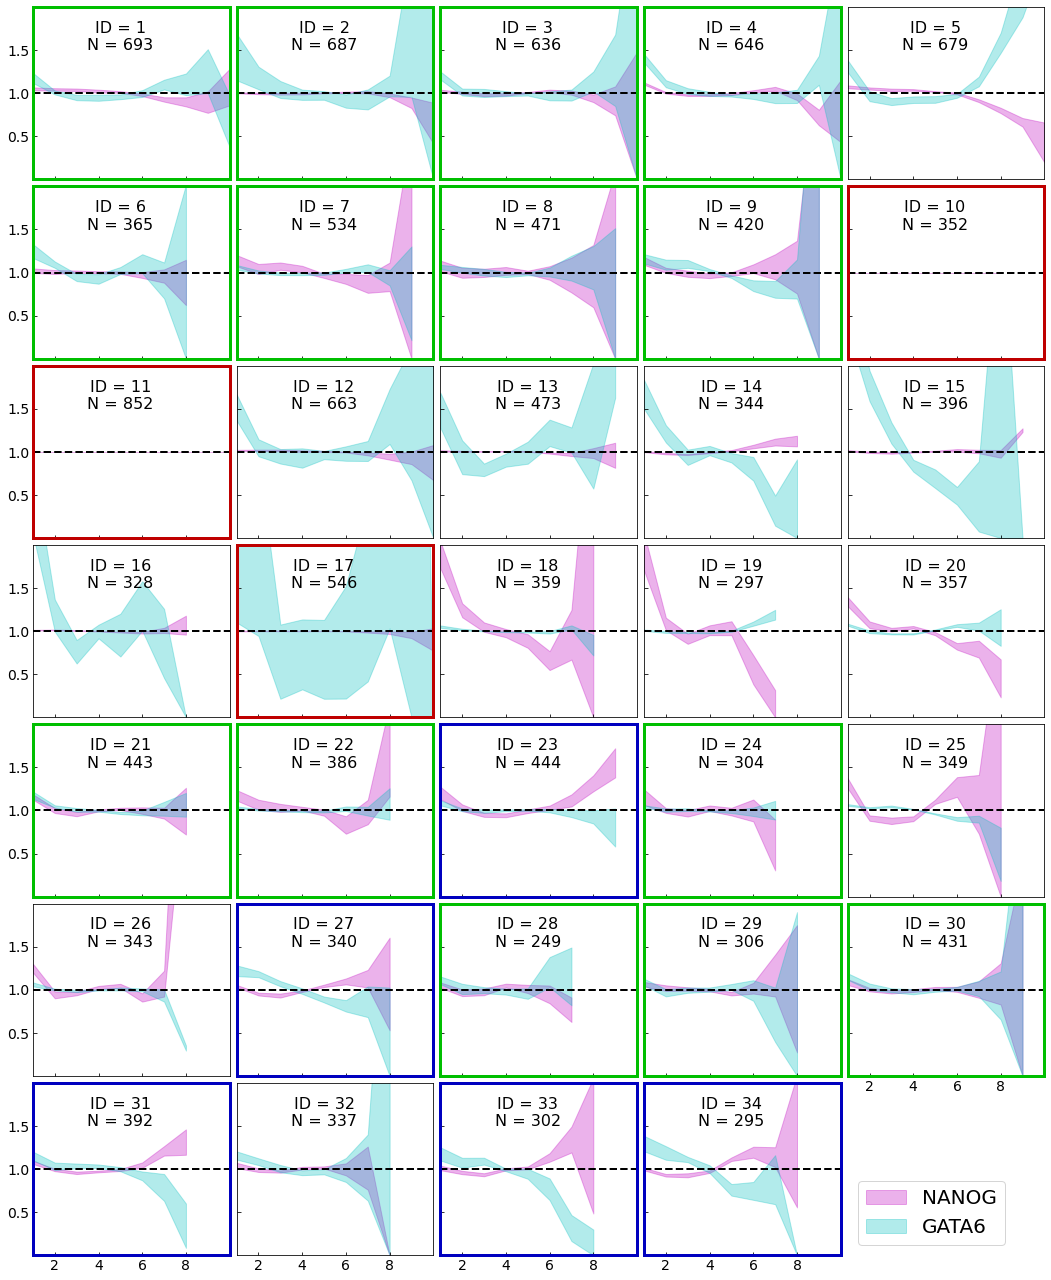

In [189]:
maxlen = 0
maxval = 0
for ID in IDs_24:
    dat.pcf_bounds(ID, 1000, plot=False)
    if len(dat.pcf[ID][0]) > maxlen:
        maxlen = len(dat.pcf[ID][0])
    if dat.pcf[ID].max() > maxval:
        maxval = dat.pcf[ID].max()

dist = list(range(1,maxlen+1))

m = 5
n = int(len(IDs_24)/m)+1
green = [1, 2, 3, 4, 6, 7, 8, 9, 21, 22, 24, 28, 29, 30]
blue = [23, 27, 31, 33, 34]
red = [10, 11, 17]
plt.figure(figsize=(3*m,3*n-3))
plt.rc('font', size=14)
for i, ID in enumerate(IDs_24+[1000]):
    
    if ID == 1000:
        N0, G0 = [0], [0]
        N1, G1 = [0], [0]
        
    else:
        N0 = dat.pcf[ID][0]
        N1 = dat.pcf[ID][2]

        G0 = dat.pcf[ID][3]
        G1 = dat.pcf[ID][5]
    
    dist = list(range(1,len(N0)+1))
    plt.subplot(n, m, i+1)
    plt.fill_between(dist, N0, N1, color='m', alpha=0.3)
    plt.fill_between(dist, G0, G1, color='c', alpha=0.3)
    plt.xlim([1,maxlen])
    plt.ylim([0,2])
    if (i % m) == 0:
        plt.yticks([.5,1,1.5])
    else:
        plt.yticks([.5,1,1.5], labels=[])
        
    if i >= len(IDs_24)-m:
         plt.xticks(np.arange(2, maxlen, 2.0))
    else:
         plt.xticks(np.arange(2, maxlen, 2.0), labels=[])
    if ID == 1000:
        plt.legend(['NANOG', 'GATA6'], fontsize=20, loc='lower left')
        plt.axis('off')
    else:
        plt.text(maxlen/2, 1.5, 'ID = '+str(i+1)+'\nN = '+str(dat.info(ID, output=True)[1]), fontsize=16, ha='center')
        plt.axhline(1, lw=2, linestyle='dashed', color='k')
       
    if i+1 in green:
        ax = plt.gca()
        plt.setp(ax.spines.values(), linewidth=3, color=[0,.75,0,1])
    elif i+1 in red:
        ax = plt.gca()
        plt.setp(ax.spines.values(), linewidth=3, color=[.75,0,0,1])
    elif i+1 in blue:
        ax = plt.gca()
        plt.setp(ax.spines.values(), linewidth=3, color=[0,0,.75,1])

    plt.tick_params(direction="in")

#plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.tight_layout(h_pad=-0.75, w_pad=.5)
plt.savefig('Results/PhD Thesis/Exp data/24h.pdf', transparent=True, layout='tight')
plt.savefig('Results/PhD Thesis/Exp data/24h.png', transparent=True, layout='tight')

C:\Users\sis85wc\Desktop\Cell-Differentiation\ExpData.py:158: RuntimeWarning: invalid value encountered in double_scalars
  I[j] = len(y)/np.sum(W)*numerator/denominator


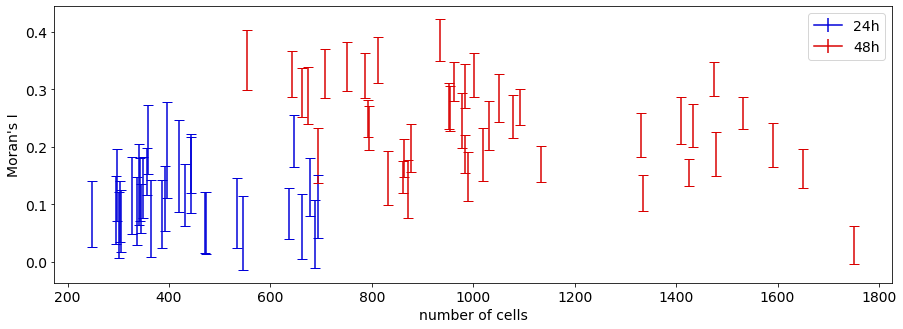

In [155]:
IDs = list(range(1,77))
for ID in IDs:
    dat.moran_bounds(ID, 1000)

plt.figure(figsize=[12.8, 4.8])
plt.rc('font', size=14)
for i, ID in enumerate(IDs_24):
    y = (dat.moran[ID][0] + dat.moran[ID][2])/2
    plt.errorbar(dat.info(ID, output=True)[1], y, yerr=dat.moran[ID][2]-y, color=[0,0,.85,1], capsize=5)
    
for i, ID in enumerate(IDs_48):
    y = (dat.moran[ID][0] + dat.moran[ID][2])/2
    plt.errorbar(dat.info(ID, output=True)[1], y, yerr=dat.moran[ID][2]-y, color=[.85,0,0,1], capsize=5)


plt.errorbar([1000], [0.2], yerr=0, color=[0,0,.85,1], label='24h')
plt.errorbar([1000], [0.2], yerr=0, color=[.85,0,0,1], label='48h')

plt.legend()
plt.xlabel('number of cells')
plt.ylabel('Moran\'s I')
plt.tight_layout()
plt.savefig('Results/PhD Thesis/Exp data/Moran.pdf', transparent=True)
plt.savefig('Results/PhD Thesis/Exp data/Moran.png', transparent=True)

In [261]:
vals = []
nums = []
for ID in IDs:
    if dat.moran[ID][1] == dat.moran[ID][1]:
        vals.append(dat.moran[ID][1])
        nums.append(dat.info(ID, output=True)[1])

cor = np.corrcoef(np.log(nums), vals)
print(cor)

[[1.         0.47091553]
 [0.47091553 1.        ]]


In [114]:
int(5000*(235-48)/235)

3978.723404255319

### Cell division matching organoids

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Organoid import Organoid

q = 0.1
nofSims = 100
DF = pd.DataFrame()
time = 48

print('i = ', end=' ')
for i in range(nofSims):
    print(i, end=' ')
    org = Organoid()
    org.nofSteps = int(5000*235/235)
    org.evolution(T=235, dim=3, maxCells=200, ignore=['transcription'])
    
    #org.nofSteps = 100
    #org.evolution(T=10, dim=3, ignore=['transcription', 'division'])
    
    org.reset_TF()

    org.eps_N = np.random.uniform(-6,-7.86)
    org.signal = 'dispersion'
    org.q = q
    org.nofSteps = int(5000*time/235)
    org.evolution(T=time, dim=3)
    org.moran()

    df = pd.DataFrame()
    df['ID'] = i*np.ones(org.nofCells, dtype=int)
    df['x-Position'] = org.pos[:,0]
    df['y-Position'] = org.pos[:,1]
    df['z-Position'] = org.pos[:,2]
    df['Radius'] = org.r
    df['N'] = org.N
    df['G'] = org.G
    df['eps_N'] = org.eps_N*np.ones(org.nofCells)
    df['Moran'] = org.Morans_I

    DF = DF.append(df)

DF.to_csv('Results/PhD Thesis/Cell division exp match/q='+str(q)+'_'+str(time)+'h.csv', index=False)

i =  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [71]:
DF = add_ratio(DF)

In [72]:
DF.Moran.unique(), DF.ratio.unique()

(array([ 0.00348642, -0.01697071,  0.08406012, -0.0420938 ,  0.04491182,
        -0.05843301,  0.02874545, -0.05122632, -0.01619264, -0.0436873 ,
         0.03280363, -0.02128085,  0.00872648,  0.05579692,  0.04924039,
         0.00127598,  0.04398416, -0.01015458,  0.01783892, -0.04510813,
         0.03588839,  0.02570662,  0.01751928, -0.04039281, -0.00487581,
         0.01030225, -0.05257533, -0.03639057,  0.04132332, -0.01934808,
        -0.04705645,  0.02725522,  0.00906884, -0.04899319,  0.06541917,
        -0.0420896 , -0.06635944,  0.00074178,  0.05296926, -0.02402583,
         0.01371954,  0.029357  ,  0.060314  ,  0.00368975, -0.02490443,
        -0.04485081,  0.03093854,  0.05716791,  0.02991936,  0.03266348,
        -0.02181785,  0.00475564,  0.01041827, -0.0179396 ,  0.02990304,
        -0.06007128, -0.02120027,  0.07130295,  0.0302393 ,  0.0203609 ,
        -0.00675195,  0.05572188, -0.04127447,  0.03725266,  0.06019892,
        -0.01209232,  0.01952836,  0.0294106 , -0.0

In [14]:
from ExpData import ExpData

dat = ExpData('Data/includingSurfaceDistance/extendedRawDataICMOrganoids.csv')
    
IDs = list(range(1,77))
for ID in IDs:
    dat.moran_bounds(ID, 1000)

C:\Users\sis85wc\Desktop\Cell-Differentiation\ExpData.py:158: RuntimeWarning: invalid value encountered in double_scalars
  I[j] = len(y)/np.sum(W)*numerator/denominator


No handles with labels found to put in legend.


0.7904260323798378 Organoids remain for q=0.1
0.630995593909093 Organoids remain for q=0.2
0.7606422575214449 Organoids remain for q=0.3
0.7496691028370835 Organoids remain for q=0.4
0.6498481851221419 Organoids remain for q=0.5
0.7310976307657091 Organoids remain for q=0.6
0.7607312555367641 Organoids remain for q=0.7
0.7901248711192577 Organoids remain for q=0.8
0.659707127330969 Organoids remain for q=0.9


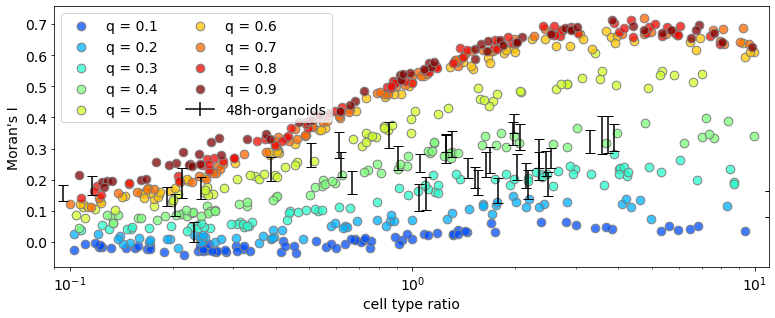

In [27]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

time = 48

def add_ratio(df):
    ratio = []
    for ID in df.ID.unique():
        test = df[df.ID == ID]
        if len(test[test.N <= test.G]) == 0:
            r = np.inf
        else:
            r = len(test[test.N > test.G])/len(test[test.N <= test.G])
        ratio += [r]*len(test)

    df['ratio'] = ratio
    return df

def exclude_ratios(df, val=2):
    new_df = df[(df.ratio > 1/val) & (df.ratio < val)]
    
    return new_df

IDs = list(range(1,77))
IDs_24 = []
IDs_48 = []
for ID in IDs:
    if dat.info(ID, output=True)[0] == '24h':
        IDs_24.append(ID)
    if dat.info(ID, output=True)[0] == '48h':
        IDs_48.append(ID)

IDs = list(range(1,77))
for ID in IDs:
    dat.moran_bounds(ID, 1000)

plt.figure(figsize=[12.8, 4.8])
plt.rc('font', size=14)

if time == 24:
    for i, ID in enumerate(IDs_24):
        y = (dat.moran[ID][0] + dat.moran[ID][2])/2

        plt.errorbar(dat.info(ID, output=True)[3]/dat.info(ID, output=True)[2],
                     y, yerr=dat.moran[ID][2]-y, color=[0,0,0,1], capsize=5, zorder=100)
elif time == 48:  
    for i, ID in enumerate(IDs_48):
        y = (dat.moran[ID][0] + dat.moran[ID][2])/2
       #plt.errorbar(dat.info(ID, output=True)[1], y, yerr=dat.moran[ID][2]-y, color=[.85,0,0,1], capsize=5)
        plt.errorbar(dat.info(ID, output=True)[3]/dat.info(ID, output=True)[2],
                     y, yerr=dat.moran[ID][2]-y, color=[0,0,0,1], capsize=5, zorder=100)


#plt.errorbar([1000], [0.2], yerr=0, color=[0,0,.85,1], label='24h')
#plt.errorbar([1000], [0.2], yerr=0, color=[.85,0,0,1], label='48h')

plt.legend()
plt.xlabel('cell type ratio')
plt.ylabel('Moran\'s I')

cmap = matplotlib.cm.get_cmap('jet')
test = np.linspace(0,1,11)

for i in range(1,10):
    
    rgba = list(cmap(test[i+1]))
    rgba[-1] = 0.75
    df = pd.read_csv('Results/PhD Thesis/Cell division exp match/q=0.'+str(i)+'_'+str(time)+'h.csv')
    
    df = add_ratio(df)
    before = len(df)
    df = exclude_ratios(df, val=10)
    after = len(df)
    print(np.array(after)/np.array(before), 'Organoids remain for q=0.'+str(i))
    mean = df.groupby(['ID']).nth(0).reset_index().mean().Moran
    std = df.groupby(['ID']).nth(0).reset_index().std().Moran
    #plt.axhline(mean, color=rgba)
    #plt.fill_between([150, 1900], [mean-std, mean-std], [mean+std, mean+std], color=rgba, alpha = 0.3)
    size = df.groupby(['ID']).nth(0).ratio
    Moran = df.groupby(['ID']).nth(0).Moran
    plt.scatter(size, Moran, color=rgba, edgecolor='gray', label = 'q = 0.'+str(i), s=75)

plt.errorbar([1], [0.2], yerr=0, color=[0,0,0,1], label=str(time)+'h-organoids')
plt.legend(ncol=2)
plt.xscale('log')
plt.xlim([0.09,11])
plt.savefig('Results/PhD Thesis/Cell division exp match/Moran_'+str(time)+'.pdf', transparent=True)
plt.savefig('Results/PhD Thesis/Cell division exp match/Moran_'+str(time)+'.png', transparent=True)

In [34]:
org = Organoid()
org.evolution(T=235, dim=2, ignore=['transcription'])
org.dist.max(), org.nofCells

(18.64712910535868, 352)

In [27]:
dat.info(ID)

Organoid 68 is 48h old
Organoid 68 consists of 831 cells
Organoid 68 consists of 237 NANOG cells
Organoid 68 consists of 260 GATA6 cells


In [16]:
size = df.groupby(['ID']).ratio

In [178]:
df.groupby(['ID']).nth(0).reset_index().mean().Moran

0.1085277882856359

In [72]:
df.groupby(['ID']).size()

ID
0     1405
26    1408
27    1394
45    1369
56    1401
73    1387
78    1397
83    1415
86    1392
87    1396
88    1368
94    1366
97    1392
99    1377
dtype: int64

In [124]:
df.groupby('ID').size()

ID
1     1381
3     1402
4     1403
5     1365
7     1404
14    1421
18    1398
23    1408
30    1426
32    1388
34    1383
43    1416
45    1367
55    1419
56    1400
58    1390
60    1386
62    1396
72    1370
73    1407
74    1398
75    1382
80    1384
83    1424
84    1406
85    1377
90    1415
91    1431
93    1402
94    1355
95    1426
dtype: int64

In [67]:
from scipy.spatial import Delaunay
from scipy.spatial.distance import cdist
import numpy as np
import igraph as ig
import itertools

x = np.zeros(len(df_wtf))
x[df_wtf.N > df_wtf.G] = 1
dist = cdist(df_wtf[['x-Position', 'y-Position', 'z-Position']].to_numpy(),df_wtf[['x-Position', 'y-Position', 'z-Position']].to_numpy())


rr = df_wtf.Radius.to_numpy() + df_wtf.Radius.to_numpy()[:,None]
tri = Delaunay(df_wtf[['x-Position', 'y-Position', 'z-Position']].to_numpy())
A = np.zeros([len(df_wtf), len(df_wtf)])
for nodes in tri.simplices:
    for path in list(itertools.combinations(nodes, 2)):
        if dist[path[0],path[1]] < rr[path[0],path[1]]:
            A[path[0],path[1]] = 1
            A[path[1],path[0]] = 1

G = ig.Graph.Adjacency(A, mode="undirected")
GraphDist = np.array(G.shortest_paths())

W = np.copy(GraphDist)
W[W > 1] = 0
y = x - x.mean()

numerator = np.dot(y, np.dot(W, y))
denominator = np.sum(y**2)

Morans_I = len(df_wtf)/np.sum(W)*numerator/denominator
print(Morans_I)

0.978386167146974
1.5448916834831625


In [84]:
 test.eps_N

1405   -7.13434
1406   -7.13434
1407   -7.13434
1408   -7.13434
1409   -7.13434
         ...   
2766   -7.13434
2767   -7.13434
2768   -7.13434
2769   -7.13434
2770   -7.13434
Name: eps_N, Length: 1366, dtype: float64

In [65]:
EV = np.linalg.eigvals(W)

EV.max()

(7.869746216076606+0j)

### Simulation on Organoids

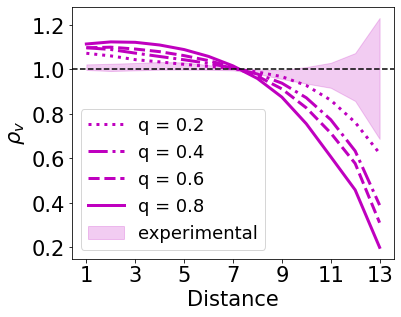

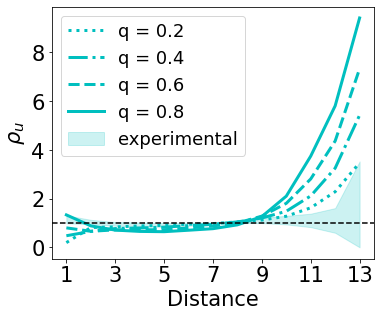

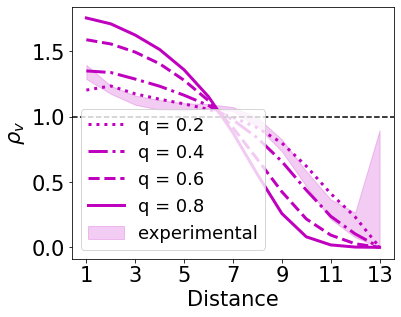

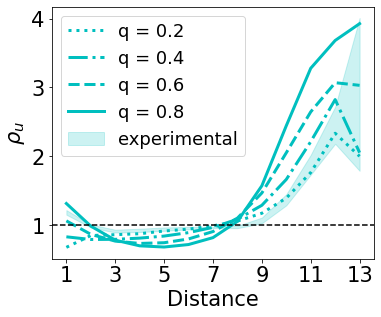

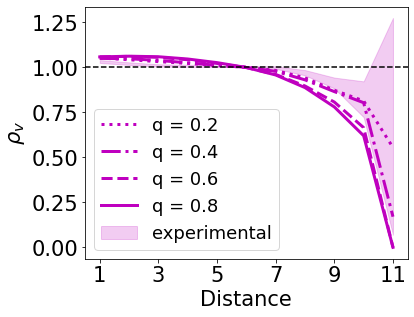

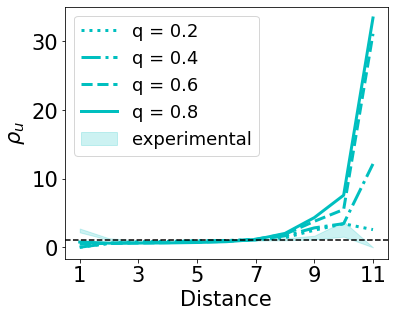

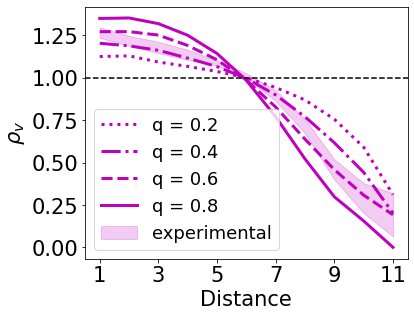

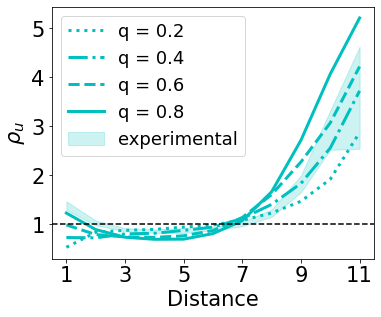

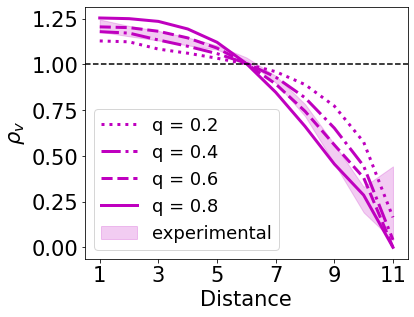

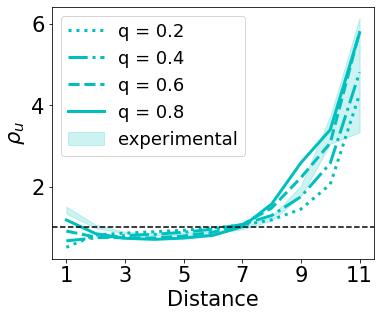

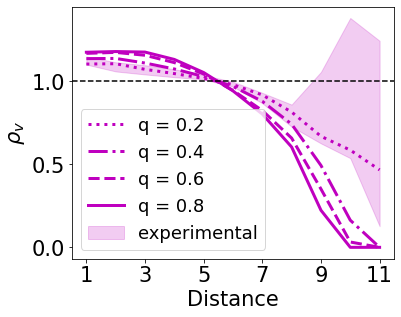

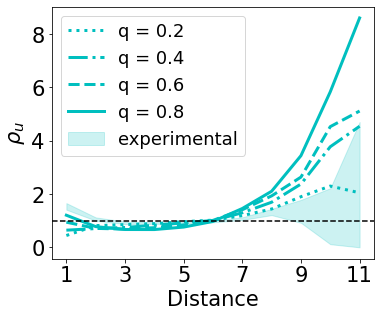

In [111]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from Functions import graphdistance3D, loadExpData, pc_bounds
from ExpData import ExpData
from Organoid3D import Organoid

IDs = [7, 14, 29, 52, 62, 65] #[20, 68]
Q = [0.2,0.4,0.6,0.8]
styles = ['dotted', 'dashdot', 'dashed', 'solid']

dat = ExpData('Data/includingSurfaceDistance/extendedRawDataICMOrganoids.csv')

for ID in IDs:
    dat.pcf_bounds(ID, 1000, plot = False)
    
    # NANOG
    plt.figure(figsize=[6.4, 4.8])
    plt.rc('font', size=14*1.5)
    for i, q in enumerate(Q):

        org = Organoid()
        org.initialConditions('Results/Publications/Signal Range/Simulation on Organoids/Organoid '+str(ID)+' q='+str(q)+' mean+2std.csv')
        Data = pd.read_csv('Results/Publications/Signal Range/Simulation on Organoids/Organoid '+str(ID)+' q='+str(q)+' mean+2std.csv')
        org.N = Data['Nanog'].to_numpy()
        org.G = Data['Gata6'].to_numpy()
        org.GraphDist = dat.GraphDist[ID]
        org.pcf(plot = False)

        ranges = list(range(1,len(org.pcf_N)+1))
        plt.plot(ranges, org.pcf_N, 'm', lw=3, linestyle=styles[i], label='q = '+str(q))
        plt.xlabel('Distance')
        plt.ylabel('$\\rho_v$')

    ranges = list(range(1,len(org.pcf_N)+1))
    plt.axhline(1, color='black', linestyle='dashed')
    plt.fill_between(ranges, dat.pcf[ID][0], dat.pcf[ID][2], color='m', alpha=0.2, label='experimental')
    plt.legend(fontsize=18)
    xticks = list(range(1,int(np.max(org.GraphDist))+1, 2))
    plt.xticks(xticks)
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.gcf().subplots_adjust(left=0.2)
    plt.savefig("Results/PhD Thesis/Exp data/PCF v ID = " + str(ID) + ".pdf", transparent=True)
    plt.savefig("Results/PhD Thesis/Exp data/PCF v ID = " + str(ID) + ".png", transparent=True)

    # GATA6
    plt.figure(figsize=[6.4, 4.8])
    plt.rc('font', size=14*1.5)
    for i, q in enumerate(Q):

        org = Organoid()
        org.initialConditions('Results/Publications/Signal Range/Simulation on Organoids/Organoid '+str(ID)+' q='+str(q)+' mean+2std.csv')
        Data = pd.read_csv('Results/Publications/Signal Range/Simulation on Organoids/Organoid '+str(ID)+' q='+str(q)+' mean+2std.csv')
        org.N = Data['Nanog'].to_numpy()
        org.G = Data['Gata6'].to_numpy()
        org.GraphDist = dat.GraphDist[ID]
        org.pcf(plot = False)

        ranges = list(range(1,len(org.pcf_G)+1))
        plt.plot(ranges, org.pcf_G, 'c', lw=3, linestyle=styles[i], label='q = '+str(q))
        plt.xlabel('Distance')
        plt.ylabel('$\\rho_u$')

    ranges = list(range(1,len(org.pcf_G)+1))
    plt.axhline(1, color='black', linestyle='dashed')
    plt.fill_between(ranges, dat.pcf[ID][3], dat.pcf[ID][5], color='c', alpha=0.2, label='experimental')
    plt.legend(fontsize=18)
    xticks = list(range(1,int(np.max(org.GraphDist))+1, 2))
    plt.xticks(xticks)
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.gcf().subplots_adjust(left=0.2)
    plt.savefig("Results/PhD Thesis/Exp data/PCF u ID = " + str(ID) + ".pdf", transparent=True)
    plt.savefig("Results/PhD Thesis/Exp data/PCF u ID = " + str(ID) + ".png", transparent=True)

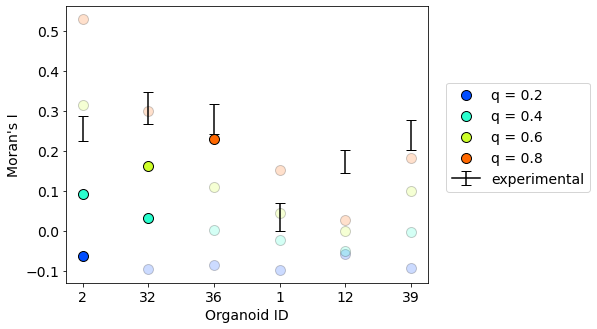

In [215]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from Functions import graphdistance3D, loadExpData, pc_bounds
from ExpData import ExpData
from Organoid3D import Organoid

cmap = matplotlib.cm.get_cmap('jet')
test = np.linspace(0,1,6)

IDs = [14, 52, 62, 7, 29, 65] #[20, 68]
Q = [0.2,0.4,0.6,0.8]
styles = ['dotted', 'dashdot', 'dashed', 'solid']

#dat = ExpData('Data/includingSurfaceDistance/extendedRawDataICMOrganoids.csv')

plt.figure(figsize=[9, 4.8])
plt.rc('font', size=14)
for k, ID in enumerate(IDs):
    dat.moran_bounds(ID, 1000)
    
    for i, q in enumerate(Q):
        rgba = list(cmap(test[i+1]))

        org = Organoid()
        org.initialConditions('Results/Publications/Signal Range/Simulation on Organoids/Organoid '+str(ID)+' q='+str(q)+' mean+2std.csv')
        Data = pd.read_csv('Results/Publications/Signal Range/Simulation on Organoids/Organoid '+str(ID)+' q='+str(q)+' mean+2std.csv')
        org.N = Data['Nanog'].to_numpy()
        org.G = Data['Gata6'].to_numpy()
        org.GraphDist = dat.GraphDist[ID]
        org.moran()

        if ID == 14 and (q == 0.2 or q == 0.4):
            alpha = 1
        elif ID == 52 and (q == 0.4 or q == 0.6):
            alpha = 1
        elif ID == 62 and (q == 0.8):
            alpha = 1
        else:
            alpha = 0.2
        if k == len(IDs)-1:
            plt.scatter(k, org.Morans_I, s=100, color=rgba, edgecolors='k', label='q = '+str(q), alpha=alpha)
        else:
            plt.scatter(k, org.Morans_I, s=100, color=rgba, edgecolors='k', alpha=alpha)

    y1, y2 = dat.moran[ID][0], dat.moran[ID][2]
    y = (y2+y1)/2
    yerr = (y2-y1)/2
    if k == len(IDs)-1:
        plt.errorbar(k, y, yerr=yerr, color='k', capsize=5, label='experimental')
    else:
        plt.errorbar(k, y, yerr=yerr, color='k', capsize=5)

xticks = list(range(1,int(np.max(org.GraphDist))+1, 2))
plt.xticks(ticks=list(range(len(IDs))), labels=[2, 32, 36, 1, 12, 39])
plt.xlabel('Organoid ID')
plt.ylabel('Moran\'s I')
leg = plt.legend(loc='upper center', bbox_to_anchor=(1.25, .75))
for lh in leg.legendHandles:
    lh.set_alpha(1)
    
plt.tight_layout()
plt.savefig("Results/PhD Thesis/Exp data/moran_simulation.pdf", transparent=True)
plt.savefig("Results/PhD Thesis/Exp data/moran_simulation.png", transparent=True)

TransformedBbox(
    Bbox(x0=15.119999999999997, y0=13.678025000000012, x1=704.8799999999999, y1=67.62540000000001),
    Affine2D(
        [[0.01388889 0.         0.        ]
         [0.         0.01388889 0.        ]
         [0.         0.         1.        ]]))


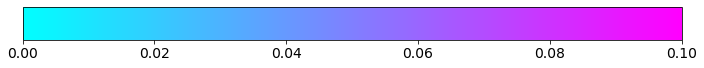

In [167]:
import numpy as np
import matplotlib.pyplot as plt

a = np.array([[0,0.1]])
fig = plt.figure(figsize=(10, 4))
plt.rc('font', size=14)
img = plt.imshow(a, cmap="cool")
plt.gca().set_visible(False)
plt.colorbar(orientation="horizontal", ticks=[0,0.02,0.04,0.06,0.08,0.1])
#plt.gcf().subplots_adjust(top=1, bottom = .5)
plt.tight_layout()

plt.savefig("Results/PhD Thesis/colorbar.pdf", transparent=True, bbox_inches="tight", pad_inches=0.2)
plt.savefig("Results/PhD Thesis/colorbar.png", transparent=True, bbox_inches="tight")

In [204]:
import pandas as pd

Data = pd.read_csv("Data/MouseHadjLab.csv", skiprows=2)
ICM = Data[Data.Population != "TE"]

total = []
Epi = []
PrE = []
for i in ICM.EmbryoID.unique():
    embryo = Data[Data.EmbryoID == i]
    if len(embryo) >= 90:
        ICM = embryo[embryo.Population != "TE"]


        total.append(len(ICM))
        Epi.append(len(ICM[ICM.Population == "PRE"]))
        PrE.append(len(ICM[ICM.Population == "EPI"]))
    
total = np.array(total)
Epi = np.array(Epi)
PrE = np.array(PrE)
print(np.mean(Epi/total), np.mean(PrE/total))
print(np.std(Epi/total), np.std(PrE/total))

0.5094229490944724 0.2962970801000812
0.1341851055629289 0.18060305291581058


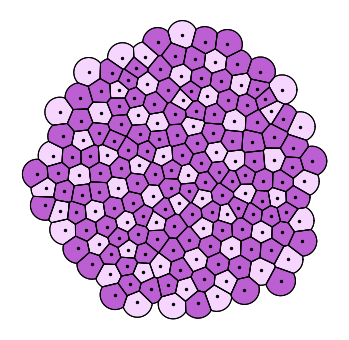

In [270]:
from Organoid import Organoid
from shapely.geometry import Point, Polygon
from scipy.spatial.distance import cdist

def test(org):
    if org.dim == 2:
        r = org.r.mean()*np.ones(org.nofCells)

        #### polygon construction ####
        polygons = []

        cells = [Point(org.pos[i,:]).buffer(r[i]) for i in range(org.nofCells)]
        if org.nofCells == 1:
            polygons.append(cells[0])
        else:
            org.dist = cdist(org.pos, org.pos)
            for i in range(org.nofCells):
                indices = np.where((org.dist[i,:] < r[i] + r[:]) & (org.dist[i,:] != 0))
                cell1 = cells[i]

                d = org.dist[i,indices[0]]
                r_neigh = r[indices] 
                a = (r[i]**2 - r_neigh**2 + d**2)/(2*d)
                d12 = org.pos[indices[0],:] - org.pos[i,:]
                d12_orth = np.array([d12[:,1],-d12[:,0]]).T

                rect1 = org.pos[i,:] + d12/d[:,None]*a[:,None] + d12_orth/d[:,None]*r[i]
                rect2 = org.pos[i,:] - d12/d[:,None]*r[i] + d12_orth/d[:,None]*r[i]
                rect3 = org.pos[i,:] - d12/d[:,None]*r[i] - d12_orth/d[:,None]*r[i]
                rect4 = org.pos[i,:] + d12/d[:,None]*a[:,None] - d12_orth/d[:,None]*r[i]

                for j in range(len(indices[0])):

                    rectangle = np.array([rect1[j,:],rect2[j,:],rect3[j,:],rect4[j,:]])
                    rectangle = Polygon(rectangle)

                    cell1 = cell1.intersection(rectangle)

                polygons.append(cell1)    

        #### plot polygons ####

        for i in range(org.nofCells):
            x, y = polygons[i].exterior.xy
            plt.plot(x, y, 'k', lw=1)

        NANOGs = np.where(org.G > org.N)[0]
        GATA6s = np.where(org.N >= org.G)[0]
        for i in NANOGs:
            x,y = polygons[i].exterior.xy
            plt.fill(x,y, facecolor='#F6D5FF', edgecolor='k', linewidth=1, zorder=1)
        for i in GATA6s:
            x,y = polygons[i].exterior.xy
            plt.fill(x,y, facecolor='#BC5FD3', edgecolor='k', linewidth=1, zorder=1)

        #### plot cell nuclei ####
        plt.scatter(org.pos[:,0],org.pos[:,1], color='k', s = 1000/len(org.pos), zorder=2)
        plt.axis('equal')
        plt.axis('off')
        
    return

plt.figure(figsize=(6,6))
org = Organoid()
org.eps_N = -7.6
org.evolution(T=200, file='Organoid_mid.csv', ignore=['division', 'displacement'])
test(org)
plt.savefig('eps_u='+str(-org.eps_N)+'.png', transparent=True)

Text(0, 0.5, 'number of cells')

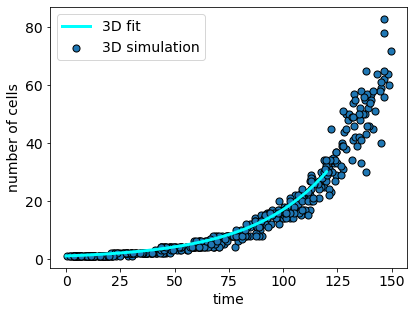

In [8]:
import numpy as np
from Organoid import Organoid
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

N = 500
T = np.random.uniform(0,150,N)

nofCells3D = np.empty(N)
for j in range(N):
    org = Organoid()
    org.k = 0.083
    org.evolution(T=T[j], dim=3, ignore=['transcription', 'displacement'])
    nofCells3D[j] = org.nofCells
    
plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
plt.scatter(T, nofCells3D, linewidths=1, edgecolors='k', label='3D simulation', s=50)

t = np.linspace(0,150,1000)
f = lambda x, a: np.exp(a*x)

popt3D, pcov = curve_fit(f, T, nofCells3D, p0=0.03)
plt.plot(t, f(t,*popt3D), color='cyan', lw=3, label='3D fit')
plt.legend()
#plt.yscale('log')
plt.xlabel('time')
plt.ylabel('number of cells')

[108.9507682] [113.45654391] [131.74260215]


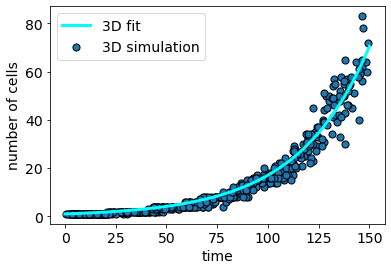

In [10]:
t = np.linspace(0,150,1000)
plt.scatter(T, nofCells3D, linewidths=1, edgecolors='k', label='3D simulation', s=50)
plt.plot(t, f(t,*popt3D), color='cyan', lw=3, label='3D fit')
plt.legend()
plt.xlabel('time')
plt.ylabel('number of cells')
print(np.log(22)/popt3D, np.log(25)/popt3D, np.log(42)/popt3D)

In [2]:
import pandas as pd
import numpy as np
from Organoid import Organoid
import matplotlib.pyplot as plt


T = [108.95, 113.46, 131.74]
stage = ['early', 'mid', 'late']

for k, t in enumerate(T):
    DF = pd.DataFrame()
    for i in range(1000):
        print(i, end=' ')
        org = Organoid()
        org.nofSteps = int(5000*t/235)
        org.signal = 'dispersion'
        org.q = np.random.uniform(0,1)
        org.eps_N = np.random.uniform(-6,-7.86)
        org.evolution(T=t, dim=3)

        df = pd.DataFrame()
        df['ID'] = np.full(org.nofCells, i)
        df['x-Position'] = org.pos[:,0]
        df['y-Position'] = org.pos[:,1]
        df['z-Position'] = org.pos[:,2]
        df['Radius'] = org.r
        df['u'] = org.N
        df['v'] = org.G
        df['q'] = org.q
        df['eps_u'] = org.eps_N

        DF = DF.append(df)
    
    DF.to_csv('Results/'+stage[k]+'_(1000 organoids).csv', index=False)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 

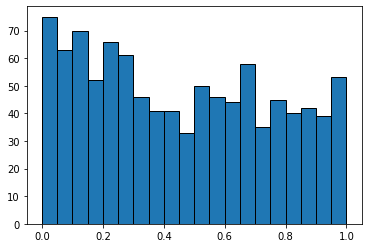

In [3]:
prop = []
for i in range(1000):
    X = DF[DF.ID == i]
    N = X.u.to_numpy()
    G = X.v.to_numpy()
    prop.append(len(N[N>G])/len(N))
    
plt.hist(prop, 20, edgecolor='k');

In [7]:
org.divDist

0.22982524892850528

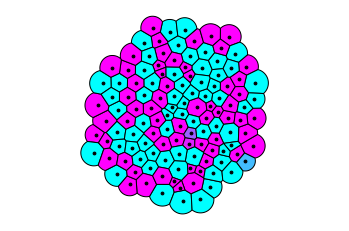

In [4]:
from Organoid import Organoid
org = Organoid()

org.evolution(T=200)
org.cellPlot(org.G)